### **Ia. Libraries**<a class = "anchor" id = "Ia"></a>

#### **a. Data Engineering and Visualization Libraries**

In [ ]:
# libraries for dataframe manipulation
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

# libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# library to make bold characters in the output cells
import sys
!{sys.executable} -m pip install termcolor
from termcolor import colored

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### **b. Machine Learning Libraries**

In [ ]:
# library to split a dataframe into Train and Test dataframes
from sklearn.model_selection import train_test_split

# libraries for feature selection
from sklearn.feature_selection import SelectKBest
    # 1. ANOVA
from sklearn.feature_selection import f_classif
    # 2. Kendall's Tau
from scipy.stats import kendalltau
    # 3. Chi-Squared
from sklearn.feature_selection import chi2
    # 4. Mutual Information
from sklearn.feature_selection import mutual_info_classif

# library to help selecting the best parameter configuration for the model
from sklearn.model_selection import GridSearchCV

# libraries to build the machine learning models
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import files
uploaded = files.upload()
from google.colab import files
uploaded = files.upload()

Saving test1.csv to test1.csv


### **Ib. Dataframes**<a class = "anchor" id = "Ib"></a>

In [ ]:

# original train dataset to serve as reset checkpoint
train_ori = pd.read_csv('train_10K_test.csv')

# copy of train dataset
train = train_ori.copy()

# original test dataset to serve as reset checkpoint
test_ori = pd.read_csv('test1.csv')

# copy of test dataset
test = test_ori.copy()

### **Ic. Functions**<a class = "anchor" id = "Ic"></a>

#### **a. Data Exploration Functions**<a class = "anchor" id = "Ic_a"></a>

In [ ]:
def missing_values_perc(df):
    # a function to return each datafame column's missing value count and its percentange

    # calculating the missing values for each column
    missing_values = df.isnull().sum()

    # turning the previous output into a dataframe format
    missing_values = pd.DataFrame(missing_values)
    missing_values = missing_values.reset_index()
    missing_values.columns = ['Column', 'Count']

    # calculating each feature's missing values percentage
    list_missing_values = []
    for i in missing_values['Count']:
        missing_values_perc = i / len(df) * 100 # Total entries = 100000 (from previous step)
        list_missing_values.append(missing_values_perc)
    list_missing_values = [round(num, 2) for num in list_missing_values]

    # adding the missing values percentage column to the report
    missing_values['Percentage (%)'] = list_missing_values

    # displaying the missing values report
    print('Missing values on each column : ', '\n')
    print(missing_values.to_string(index = False))

In [ ]:
def uniquevalueprob(dataset, feature, excludeditem = None):
    # a function to get each unique value's count and portion in a feature
    
    # getting the feature's unique values
    global listUV
    listUV = list(dataset[feature].unique())
    listUV = [i for i in listUV if type(i) is not float]
    if excludeditem is not None:
        listUV.remove(excludeditem)
    else:
        listUV = listUV
    
    # getting the count of each unique value
    global listUVcount
    listUVcount = []
    for UV in listUV:
        UVcount = (dataset[feature] == UV).sum()
        listUVcount.append(UVcount)
    
    # calculating the total count of items in the feature
    totalcount = sum(listUVcount)
    
    # calculating the portion of each unique value
    global listUVportion
    listUVportion = []
    for item in listUVcount:
        UVportion = item / totalcount
        listUVportion.append(UVportion)
    
    # creating the report table
    table = pd.DataFrame(list(zip(listUV, listUVcount, listUVportion)))
    table.columns = [feature, 'Count', 'Portion']
    
    # displaying the report table
    print(table.sort_values(['Count', feature], 
                            ascending = [0,1]).to_string(index = False))

#### **b. Feature Cleaning and Engineering Functions**<a class = "anchor" id = "Ic_b"></a>

In [ ]:
def countoutlier(dataset, feature):
    # a function to count how many outliers are present in a numerical list
    
    # calculating the outlier boundaries
    Q1 = dataset[feature].quantile(0.25)
    Q3 = dataset[feature].quantile(0.75)
    IQR = Q3 - Q1
    UBoundary = Q3 + 1.5 * IQR
    LBoundary = Q1 - 1.5 * IQR
    
    # counting the outliers
    outliercount = 0
    for i in dataset[feature]:
        if i > UBoundary or i < LBoundary:
            outliercount = outliercount + 1
        else:
            pass
    
    # displaying the outliers count report
    print('Outlier count in', feature, ':', outliercount)

In [ ]:
def omitoutlier(dataframe, feature):
    # a function to omit outliers that are present in a numerical list
    
    # calculating the outlier boundaries
    Q1 = dataframe[feature].quantile(0.25)
    Q3 = dataframe[feature].quantile(0.75)
    IQR = Q3 - Q1
    UBoundary = Q3 + 1.5 * IQR
    LBoundary = Q1 - 1.5 * IQR
    
    # creating a new list that does not contain the outliers
    newlist = []
    for i in dataframe[feature]:
        if i > UBoundary or i < LBoundary:
            newlist.append(np.nan)
        else:
            newlist.append(i)
    
    # replacing the items in the feature with the newly-created list
    dataframe[feature] = newlist
    
    # displaying the outliers ommission report
    print(feature, ' data distribution after dropping the outliers : ')
    plt.hist(dataframe[feature])
    plt.title(feature + ' Data Distribution')
    plt.xlabel(feature)
    plt.ylabel('Count')

In [ ]:
def lookupreplacement(dataset, reference, feature):    
    # a function to replace all entries in each subgroup of a numerical list based on each subgroup's mode
    
    # preparing a dataframe containing both the feature that needs the replacement and the reference feature that acts as the lookup table
    lookup = dataset[[reference, feature]]

    # returning the mode of each subgroup that is present in the reference feature
    lookup = lookup.groupby(reference).agg(pd.Series.mode)

    # replacing all entries in each subgroup of the numerical list based on each subgroup's mode
    dataset[feature] = dataset[reference].map(lookup[feature])
    
    # eliminating any array-type value generated by the replacement method using only the first member of the array value
    newlist = []
    for i in range(len(dataset[feature])):
        # for float type members
        if type(dataset[feature][i]) == np.float64:
            newlist.append(dataset[feature][i])
        # for empty list members
        elif type(dataset[feature][i]) == np.ndarray and len(dataset[feature][i]) == 0:
            newlist.append(np.nan)
        # for non-empty list members
        elif type(dataset[feature][i]) == np.ndarray and len(dataset[feature][i]) != 0:
            newlist.append(dataset[feature][i][1])
    dataset[feature] = newlist
    
    # reconverting the feature into float to make sure the data type is correct
    dataset[feature].astype(float)
    
    # displaying the remaining missing value after the replacement and array elimination process
    remaining = dataset[feature].isnull().sum()
    print('Remaining', feature, 'missing values :', remaining)

In [ ]:
def aggregatedfillna(dataset, reference, feature):
    # a function to fill nan entries present in each subgroup of a numerical list using the subgroup's mean +- standard deviation
    
    # preparing a dataframe containing both the feature that needs the nan filling and the reference feature that acts as the lookup table
    table = dataset[[reference, feature]]
    
    # locating the nan entries in the feature that needs the nan filling, followed by their reference value
    ref = table.loc[table[feature].isnull(), reference]

    # getting only the unique reference values
    ref = ref.unique()

    # converting the reference values into a list
    ref = list(ref)
    
    # creating a list with the same length as the reference values list containing empty values
    fe = []
    for i in range(len(ref)):
        fe.append(np.nan)

    # preparing the lookup table containing the reference values and the soon-to-be generated value associated to them
    featureLookup = pd.DataFrame(list(zip(ref, fe)))
    featureLookup.columns = [reference, feature]

    # calculating the mean value of the feature that needs the nan filling
    featureMean = dataset[feature].mean()

    # calculating the standard deviation value of the feature that needs the nan filling
    featureStdDev = dataset[feature].std()

    # generating the lookup value in the lokup table
    featureLookup[feature] = featureLookup[feature].fillna(pd.Series(np.random.randint(int(featureMean - featureStdDev), 
                                                                                       int(featureMean + featureStdDev),
                                                                                       size = featureLookup[feature].isnull().sum())))
    
    # filling in the nan entries in the feature that needs the nan filling with the reference to the lookup table
    dataset[feature] = dataset[feature].fillna(dataset[reference].map(featureLookup.set_index(reference)[feature]))

    # checking if there are still missing values in the feature
    remaining = dataset[feature].isnull().sum()
    print('Remaining', feature, 'missing values :', remaining)

### **Id. Color Palette**<a class = "anchor" id = "Id"></a>

## **II. Data Exploration Phase I: Get to Know the Data**<a class = "anchor" id = "II"></a>

### **IIa. General Overview**<a class = "anchor" id = "IIa"></a>

There are some information regarding what each feature of the dataset represents given by the provider of the datasets. These information are very useful for us to better understand the datasets.

* 1. ID: Represents a unique identification of an entry
* 2. Customer_ID: Represents a unique identification of a person
* 3. Month: Represents the month of the year
* 4. Name: Represents the name of a person
* 5. Age: Represents the age of the person
* 6. SSN: Represents the social security number of a person
* 7. Occupation: Represents the occupation of the person
* 8. Annual_Income: Represents the annual income of the person
* 9. Monthly_Inhand_Salary:Represents the monthly base salary of a person
* 10. Num_Bank_Accounts: Represents the number of bank accounts a person holds
* 11. Num_Credit_Card: Represents the number of other credit cards held by a person
* 12. Interest_Rate: Represents the interest rate on credit card
* 13. Num_of_Loan: Represents the number of loans taken from the bank
* 14. Type_of_Loan: Represents the types of loan taken by a person
* 15. Delay_from_due_date: Represents the average number of days delayed from the payment date
* 16. Num_of_Delayed_Payment: Represents the average number of payments delayed by a person
* 17. Changed_Credit_Limit: Represents the percentage change in credit card limit
* 18. Num_Credit_Inquiries: Represents the number of credit card inquiries
* 19. Credit_Mix: Represents the classification of the mix of credits
* 20. Outstanding_Debt: Represents the remaining debt to be paid (in USD)
* 21. Credit_Utilization_Ratio: Represents the utilization ratio of credit card
* 22. Credit_History_Age: Represents the age of credit history of the person
* 23. Payment_of_Min_Amount: Represents whether only the minimum amount was paid by the person
* 24. Total_EMI_per_month: Represents the monthly EMI payments (in USD)
* 25. Amount_invested_monthly: Represents the monthly amount invested by the customer (in USD)
* 26. Payment_Behaviour: Represents the payment behavior of the customer (in USD)
* 27. Monthly_Balance: Represents the monthly balance amount of the customer (in USD)

In [ ]:
# taking a quick look at Train dataframe
pd.set_option('display.max_columns', None)
display(train.head())
print('Rows x cols of train dataframe :', train.shape)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,"0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"0x1603,CUS_0xd40,February,Aaron Maashoh,23,821...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Rows x cols of train dataframe : (10008, 28)


In [ ]:
# taking a quick look at Test dataframe
display(test.head())
print('Rows x cols of train dataframe :', test.shape)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,"0x160a,CUS_0xd40,September,Aaron Maashoh,23,82...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"0x160c,CUS_0xd40,November,Aaron Maashoh,24,821...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"0x160d,CUS_0xd40,December,Aaron Maashoh,24_,82...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2.0,4.0,6.0,1,Credit-Builder Loan,3.0,1,5.42,5.0,Good,605.03,25.926822,27 Years and 3 Months,No,18.816215,39.684018417945296,High_spent_Large_value_payments,485.298434


Rows x cols of train dataframe : (5003, 27)


In [ ]:
# general overview of the Train dataframe
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        10008 non-null  object 
 1   Customer_ID               2186 non-null   object 
 2   Month                     2186 non-null   object 
 3   Name                      1991 non-null   object 
 4   Age                       2186 non-null   object 
 5   SSN                       2186 non-null   object 
 6   Occupation                2186 non-null   object 
 7   Annual_Income             2186 non-null   object 
 8   Monthly_Inhand_Salary     1883 non-null   float64
 9   Num_Bank_Accounts         2186 non-null   float64
 10  Num_Credit_Card           2186 non-null   float64
 11  Interest_Rate             2186 non-null   float64
 12  Num_of_Loan               2186 non-null   object 
 13  Type_of_Loan              1016 non-null   object 
 14  Delay_

None

In [ ]:
# general overview of Test dataframe
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5003 entries, 0 to 5002
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        5003 non-null   object 
 1   Customer_ID               1093 non-null   object 
 2   Month                     1093 non-null   object 
 3   Name                      985 non-null    object 
 4   Age                       1093 non-null   object 
 5   SSN                       1093 non-null   object 
 6   Occupation                1093 non-null   object 
 7   Annual_Income             1093 non-null   object 
 8   Monthly_Inhand_Salary     946 non-null    float64
 9   Num_Bank_Accounts         1093 non-null   float64
 10  Num_Credit_Card           1093 non-null   float64
 11  Interest_Rate             1093 non-null   float64
 12  Num_of_Loan               1093 non-null   object 
 13  Type_of_Loan              508 non-null    object 
 14  Delay_fr

None

### **IIb. Missing Values**<a class = "anchor" id = "IIb"></a>

In [ ]:
# reporting Train's missing values
missing_values_perc(train)

Missing values on each column :  

                  Column  Count  Percentage (%)
                      ID      0            0.00
             Customer_ID   7822           78.16
                   Month   7822           78.16
                    Name   8017           80.11
                     Age   7822           78.16
                     SSN   7822           78.16
              Occupation   7822           78.16
           Annual_Income   7822           78.16
   Monthly_Inhand_Salary   8125           81.19
       Num_Bank_Accounts   7822           78.16
         Num_Credit_Card   7822           78.16
           Interest_Rate   7822           78.16
             Num_of_Loan   7822           78.16
            Type_of_Loan   8992           89.85
     Delay_from_due_date   7822           78.16
  Num_of_Delayed_Payment   7991           79.85
    Changed_Credit_Limit   7822           78.16
    Num_Credit_Inquiries   7884           78.78
              Credit_Mix   7822           78.16
     

In [ ]:
# reporting Test's missing values
missing_values_perc(test)

Missing values on each column :  

                  Column  Count  Percentage (%)
                      ID      0            0.00
             Customer_ID   3910           78.15
                   Month   3910           78.15
                    Name   4018           80.31
                     Age   3910           78.15
                     SSN   3910           78.15
              Occupation   3910           78.15
           Annual_Income   3910           78.15
   Monthly_Inhand_Salary   4057           81.09
       Num_Bank_Accounts   3910           78.15
         Num_Credit_Card   3910           78.15
           Interest_Rate   3910           78.15
             Num_of_Loan   3910           78.15
            Type_of_Loan   4495           89.85
     Delay_from_due_date   3910           78.15
  Num_of_Delayed_Payment   3986           79.67
    Changed_Credit_Limit   3910           78.15
    Num_Credit_Inquiries   3934           78.63
              Credit_Mix   3910           78.15
     

### **IIc. Duplicated Entries**<a class = "anchor" id = "IIc"></a>

In [ ]:
# duplicated entries in Train dataframe
DuplicatedValues = train.duplicated().sum()
print('Duplicated data (train) : ' + str(DuplicatedValues))

Duplicated data (train) : 0


In [ ]:
# duplicated entries in Test dataframe
DuplicatedValues = test.duplicated().sum()
print('Duplicated data (test) : ' + str(DuplicatedValues))

Duplicated data (test) : 0


### **IId. Unique Values**<a class = "anchor" id = "IId"></a>

In [ ]:
# getting the feature names in a list
trainCols = list(train.columns.values)

# calculating the number of each feature's unique values
ListUniqueC = []
for i in train.columns:
    UCount = len(train[i].unique())
    ListUniqueC.append(UCount)

# creating the unique values table
UniqueCTable = pd.DataFrame(list(zip(trainCols, ListUniqueC)))
UniqueCTable.columns = ['Feature', 'Unique Values']

# printing the report
print('Unique values in each feature (train):')
print(UniqueCTable.to_string(index = False))

Unique values in each feature (train):
                 Feature  Unique Values
                      ID          10008
             Customer_ID            276
                   Month              9
                    Name            272
                     Age             87
                     SSN            277
              Occupation             17
           Annual_Income            293
   Monthly_Inhand_Salary            285
       Num_Bank_Accounts             31
         Num_Credit_Card             61
           Interest_Rate             70
             Num_of_Loan             14
            Type_of_Loan             10
     Delay_from_due_date             41
  Num_of_Delayed_Payment             45
    Changed_Credit_Limit            535
    Num_Credit_Inquiries             45
              Credit_Mix              4
        Outstanding_Debt            276
Credit_Utilization_Ratio           2187
      Credit_History_Age            246
   Payment_of_Min_Amount              4
 

In [ ]:
# getting the feature names in a list
testCols = list(test.columns.values)

# calculating the number of each feature's unique values
ListUniqueC = []
for i in test.columns:
    UCount = len(test[i].unique())
    ListUniqueC.append(UCount)

# creating the unique values table
UniqueCTable = pd.DataFrame(list(zip(testCols, ListUniqueC)))
UniqueCTable.columns = ['Feature', 'Unique Values']

# printing the report
print('Unique values in each feature (test):')
print(UniqueCTable.to_string(index = False))

Unique values in each feature (test):
                 Feature  Unique Values
                      ID           5003
             Customer_ID            275
                   Month              5
                    Name            272
                     Age             61
                     SSN            276
              Occupation             17
           Annual_Income            291
   Monthly_Inhand_Salary            279
       Num_Bank_Accounts             25
         Num_Credit_Card             42
           Interest_Rate             38
             Num_of_Loan             12
            Type_of_Loan             10
     Delay_from_due_date             41
  Num_of_Delayed_Payment             34
    Changed_Credit_Limit            410
    Num_Credit_Inquiries             37
              Credit_Mix              4
        Outstanding_Debt            275
Credit_Utilization_Ratio           1094
      Credit_History_Age            233
   Payment_of_Min_Amount              4
  

### **IIe. Data Exploration Findings**<a class = "anchor" id = "IIe"></a>

**Dataframe Shape**
* The shape of the train dataframe is (100000 x 28), while the shape of test dataframe is (50000 x 27). 
* The difference in number of entries is due to testing dataset displays the last four months for each customer, while the training dataset displays the first eight months.
* The difference in number of features is due to training dataset has Credit_Score feature as the output feature, while the testing dataset does not have it.


**Incorrect Data Type**

*   'Annual_Income' should be float64
*   'Num_of_Loan' should be int64
*   'Num_of_Delayed_Payment' should be int64
*   'Changed_Credit_Limit' should be float64
*   'Outstanding_Debt' should be float64
*   'Credit_History_Age' should be float64
*   'Amount_invested_monthly' should be float64
*   'Monthly_Balance' should be float 64


The data type of these features are currently in categorical type, while from our observation, the data that are actually shown in these features are numerical. We need to change this later.


**Missing Values**

Train dataframe:
*   'Name'
*   'Monthly_Inhand_Salary'
*   'Type_of_Loan'
*   'Num_of_Delayed_Payment'
*   'Num_Credit_Inquiries'
*   'Credit_History_Age'
*   'Amount_invested_monthly'
*   'Monthly_Balance'

Test dataframe:
*   'Name'
*   'Monthly_Inhand_Salary'
*   'Type_of_Loan'
*   'Num_of_Delayed_Payment'
*   'Num_Credit_Inquiries'
*   'Credit_History_Age'
*   'Amount_invested_monthly'
*   'Monthly_Balance'

**Duplicated Entries**

There are no duplicated entries in both Train and Test dataframes.

## **III. Feature Engineering: Cleaning Data Type**<a class = "anchor" id = "III"></a>

### **IIIa. Cleaning Categorical Features That Are Supposedly Numerical**<a class = "anchor" id = "IIIa"></a>

Let's first take a look at the categorical features that supposedly have numerical type of data instead.

In [ ]:
# categorical features that are supposedly to be numerical instead
FeaturesToConvert = ['Age',
                     'Annual_Income',
                     'Num_of_Loan',
                     'Num_of_Delayed_Payment',
                     'Changed_Credit_Limit',
                     'Outstanding_Debt',
                     'Amount_invested_monthly',
                     'Monthly_Balance'] 
# 'Credit_History_Age' feature will be dealt with later

# checking the unique values of these features
for feature in FeaturesToConvert:
    uniques = train[feature].unique()
    print('Feature:', '\n',
          colored(feature, attrs = ['bold']), '\n',
          uniques, '\n',
          '--'*40, '\n')

Feature: 
 Age 
 [nan '28' '54' '55' '21' '31' '20' '26' '41' '19' '32' '995' '36' '33'
 '3885' '42' '43' '25' '45' '35' '34' '500' '456' '5717' '53' '56' '22'
 '37' '48' '7140' '49' '46' '8233' '47' '6955' '50' '5112' '4872' '39'
 '40' '1772' '18' '5657' '27' '51' '52' '38' '30' '6953' '4670' '6922'
 '223' '395' '44' '7359' '23' '2109' '7183' '24' '3625' '3724' '480'
 '5610' '5784' '3542' '3513' '29' '7274' '8394' '2455' '7431' '1116'
 '4017' '5376' '3909' '6365' '15' '3967' '2297' '7705' '5154' '4155'
 '5256' '8173' '5589' '6868' '6556'] 
 -------------------------------------------------------------------------------- 

Feature: 
 Annual_Income 
 [nan '34847.84' '30689.89' '35547.71' '73928.46' '92047.08' '97791.42'
 '19514.88' '106733.13' '43070.24' '71681.4' '12909.895' '85554.03'
 '123732.32' '80108.31' '118248.6' '72330.98' '34106.78' '17001.34'
 '103353.06' '17992.775' '139354.48' '18305.25' '27865.26' '23404.86'
 '85328.73' '28665.76' '66528.24' '31122.79' '15015.4' '41345.58'

By looking at some of the entries above, one thing that could be noticed is that some of these entries contain non-numerical character, such as '-' and '_', while they are supposed to have only numerical character. We will omit both of these special characters from the features, and see if they can be converted into numerical features afterwards.

In [ ]:
# handling the empty members in each feature
for feature in FeaturesToConvert:
    train[feature] = train[feature].replace({'':np.nan})
    test[feature] = test[feature].replace({'':np.nan})

# trying converting the categorical features into numerical type
for feature in FeaturesToConvert:
    train[feature] = train[feature].astype('float64')
    test[feature] = test[feature].astype('float64')

# checking if the conversion is successful
for feature in FeaturesToConvert:
    print('train dataframe:', feature, '\n',
          train[feature].dtype)
    print('test dataframe :', feature, '\n',
          test[feature].dtype, '\n')

train dataframe: Age 
 float64
test dataframe : Age 
 float64 

train dataframe: Annual_Income 
 float64
test dataframe : Annual_Income 
 float64 

train dataframe: Num_of_Loan 
 float64
test dataframe : Num_of_Loan 
 float64 

train dataframe: Num_of_Delayed_Payment 
 float64
test dataframe : Num_of_Delayed_Payment 
 float64 

train dataframe: Changed_Credit_Limit 
 float64
test dataframe : Changed_Credit_Limit 
 float64 

train dataframe: Outstanding_Debt 
 float64
test dataframe : Outstanding_Debt 
 float64 

train dataframe: Amount_invested_monthly 
 float64
test dataframe : Amount_invested_monthly 
 float64 

train dataframe: Monthly_Balance 
 float64
test dataframe : Monthly_Balance 
 float64 



### **IIIb. Cleaning Strings in Credit_History_Age to be Numerical**<a class = "anchor" id = "IIIb"></a>

The data contained in this feature is meant to show a duration type of data, so for the sake of praticality when dealing with this data later in the analysis and prediction process, the type of data is better not be categorical, but numerical instead. Let's process the data contained in this feature.

In [ ]:
# taking a quick look again at the data
train['Credit_History_Age'].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: Credit_History_Age, dtype: object

Since the smallest unit is monthly, we are going to convert the data in monthly unit.

In [ ]:
# splitting each member of the 'Credit_History_Age' feature
SplitHistoryAge = [str(date).split(' ') for date in train['Credit_History_Age']]

# getting the year
CreditYear = [item[0] for item in SplitHistoryAge]

# Converting the year to month
CreditYear = [float(x) * 12 for x in CreditYear]

# getting the month
CreditMonth = []
for item in SplitHistoryAge:
    if len(item) > 1:
        CreditMonth.append(item[3]) # for non-nan member
    else:
        CreditMonth.append(item[0]) # for nan member

# combining the year and month
CombinedCreditAge = [float(CreditYear[i]) + float(CreditMonth[i]) for i in range(len(CreditYear))]

# assigning the combined month to the 'Credit_History_Age' feature
train['Credit_History_Age'] = CombinedCreditAge

# checking the first five rows again
train['Credit_History_Age'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: Credit_History_Age, dtype: float64

In [ ]:
# splitting each member of the 'Credit_History_Age' feature
SplitHistoryAge = [str(date).split(' ') for date in test['Credit_History_Age']]

# getting the year
CreditYear = [item[0] for item in SplitHistoryAge]

# converting the year to month
CreditYear = [float(x) * 12 for x in CreditYear]

# getting the month
CreditMonth = []
for item in SplitHistoryAge:
    if len(item) > 1:
        CreditMonth.append(item[3]) # for non-nan member
    else:
        CreditMonth.append(item[0]) # for nan member

# combining the year and month
CombinedCreditAge = [float(CreditYear[i]) + float(CreditMonth[i]) for i in range(len(CreditYear))]

# assigning the combined month to the 'Credit_History_Age' feature
test['Credit_History_Age'] = CombinedCreditAge

# checking the first five rows again
test['Credit_History_Age'].head()

0      NaN
1      NaN
2      NaN
3      NaN
4    327.0
Name: Credit_History_Age, dtype: float64

### **IIIc. Data Cleaning and Engineering Log**<a class = "anchor" id = "IIIc"></a>

**Data Cleaning and Engineering Phase 1**

In the features 'Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly', and 'Monthly_Balance' from both Train and Test dataframes, these actions were performed :
* Removed the characters '-' and '_'.
* Replacing empty values with np.nan, so that the features can be converted into float.
* Converting the features into float.

## **IV. Data Exploration 2: Categorical Features**<a class = "anchor" id = "IV"></a>

Now that the data type of each feature has been corrected, let us proceed to checking the cleanliness of each feature itself: data validation, spelling errors, missing values, outliers, feature addition or deletion (if needed).

### **IVa. General Overview**<a class = "anchor" id = "IVa"></a>

In [ ]:
# rechecking the general overview of the Train dataframe after it has been previously modified
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        10008 non-null  object 
 1   Customer_ID               2186 non-null   object 
 2   Month                     2186 non-null   object 
 3   Name                      1991 non-null   object 
 4   Age                       2186 non-null   float64
 5   SSN                       2186 non-null   object 
 6   Occupation                2186 non-null   object 
 7   Annual_Income             2186 non-null   float64
 8   Monthly_Inhand_Salary     1883 non-null   float64
 9   Num_Bank_Accounts         2186 non-null   float64
 10  Num_Credit_Card           2186 non-null   float64
 11  Interest_Rate             2186 non-null   float64
 12  Num_of_Loan               2186 non-null   float64
 13  Type_of_Loan              1016 non-null   object 
 14  Delay_

In [ ]:
# rechecking the general overview of the Test dataframe after it has been previously modified
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5003 entries, 0 to 5002
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        5003 non-null   object 
 1   Customer_ID               1093 non-null   object 
 2   Month                     1093 non-null   object 
 3   Name                      985 non-null    object 
 4   Age                       1093 non-null   float64
 5   SSN                       1093 non-null   object 
 6   Occupation                1093 non-null   object 
 7   Annual_Income             1093 non-null   float64
 8   Monthly_Inhand_Salary     946 non-null    float64
 9   Num_Bank_Accounts         1093 non-null   float64
 10  Num_Credit_Card           1093 non-null   float64
 11  Interest_Rate             1093 non-null   float64
 12  Num_of_Loan               1093 non-null   float64
 13  Type_of_Loan              508 non-null    object 
 14  Delay_fr

In [ ]:
# storing the categorical column name into a list
CatFeatures = []
for feature in train.columns:
    if train[feature].dtype == 'object':
        CatFeatures.append(feature)

# storing the numerical column name into a list
NumFeatures = []
for feature in train.columns:
    if train[feature].dtype == 'float64' or train[feature].dtype == 'int64':
        NumFeatures.append(feature)

### **IVb. Items Spelling Checking**<a class = "anchor" id = "IVb"></a>

In [ ]:
# checking the unique values of categorical features in train dataframe
for feature in CatFeatures:
    uniques = train[feature].unique()
    print('Feature:', '\n',
          colored(feature, attrs = ['bold']), '\n',
          uniques, '\n',
          'Unique values = ', len(train[feature].unique()), '\n',
          '--'*40, '\n')

Feature: 
 ID 
 ['0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.8433333333328,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan",3,7,11.27,4.0,_,809.98,26.822619623699016,22 Years and 1 Months,No,49.57494921489417,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good'
 '0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan",-1,,11.27,4.0,Good,809.98,31.94496005538421,NA,No,49.57494921489417,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good'
 '0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan",3,7,_,4.0,Good,809.98,28.60935202206993,22 Years and 3 Months,No,49.57494921489417,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good'
 ...
 '0x509f,CUS_0x229f,June,,45,547-53-2472

In [ ]:
# checking the unique values categorical features in test dataframe
for feature in CatFeatures[:-1]:
    uniques = test[feature].unique()
    print('Feature:', '\n',
          colored(feature, attrs = ['bold']), '\n',
          uniques, '\n',
          'Unique values = ', len(test[feature].unique()), '\n',
          '--'*40, '\n')

Feature: 
 ID 
 ['0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.8433333333328,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan",3,7,11.27,2022.0,Good,809.98,35.03040185583525,22 Years and 9 Months,No,49.57494921489417,236.64268203272135,Low_spent_Small_value_payments,186.26670208571772'
 '0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.8433333333328,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan",3,9,13.27,4.0,Good,809.98,33.053114497012245,22 Years and 10 Months,No,49.57494921489417,21.465380264657146,High_spent_Medium_value_payments,361.44400385378196'
 '0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.8433333333328,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan",-1,4,12.27,4.0,Good,809.98,33.811894118574465,NA,No,49.57494921489417,148.23393788500925,Low_spent_Medium_value_payments,264.67544623342997'
 ..

### **IVc. Data Exploration Findings**<a class = "anchor" id = "IVc"></a>

Findings:

*   Each customer data is presented in 8 months for Train dataframe, from January to August. The correlation between the total members of the ID and Customer_ID features match up this information, with ID having 100000 members and Customer_ID having 12500 members. For Test dataframe, each customer data is presented in 4 months, from September to December.
*   The Name feature should have 12500 members as well, matching up to the value of the Customer_ID feature. The fact that the Name feature only consists of 10140 members might imply strongly that there are some of customer's names which completely miss from the dataset.
*   The SSN feature has 12501 members, with one member having a seemingly weird data validation compared to the other members in the feature, that is: '#F%$D@*&8'.
*   There are missing values in the Occupation feature, though not in the 'nan' format.
*   The Type_of_Loan feature appears to have list values. Formatting will be needed for this feature.
*   The Payment_Behavior also has a weird data validation compared to the other members in the feature, that is: '!@9#%8'
*   Including the Occupation and Credit_Mix features, after the data with weird data validation that exists in SSN and Payment_Behavior features has been deleted, these four features will have some missing values that need to be dealt with afterwards.

## **V.  Data Cleaning and Engineering Phase 2: Categorical Features**<a class = "anchor" id = "V"></a>

### **Va. Categorical Feature: Name**<a class = "anchor" id = "Va"></a>

The Name feature usually has a purpose as a unique identifier for each entry in the dataset, in this case a unique identifier for each customer. However, since there are missing values in this column and the purpose of the feature overlaps with the Customer_ID feature anyway, the Name feature will be dropped instead.

In [ ]:
# dropping the Name feature
train.drop('Name', axis = 1, inplace = True)
test.drop('Name', axis = 1, inplace = True)

### **Vb. Categorical Feature: SSN**<a class = "anchor" id = "Vb"></a>

The '#F%$D@*&8' value will be dropped from the feature, as it contains an abnormal data validation compared to the other members in the feature.

In [ ]:
# dropping the '#F%$D@*&8' value from the SSN feature
train['SSN'] = train['SSN'].replace('#F%$D@*&8', np.nan)
test['SSN'] = test['SSN'].replace('#F%$D@*&8', np.nan)

The missing values now need to be filled in. SSN stands for Social Security Number, whose values are unique to each customer. Using this condition, we will be filling in the missing SSN values with the most frequently occuring method, with the Customer_ID feature as the reference.

In [ ]:
# filling in the missing values in SSN feature
train['SSN'] = train['SSN'].fillna(train.groupby('Customer_ID')\
                                   ['SSN']\
                                   .transform(lambda x:x.mode().iat[0]))
test['SSN'] = test['SSN'].fillna(test.groupby('Customer_ID')\
                                 ['SSN']\
                                 .transform(lambda x:x.mode().iat[0]))

### **Vc. Categorical Feature: Occupation**<a class = "anchor" id = "Vc"></a>

Similar to the SSN feature, each value in the Occupation feature is also unique to each customer, assuming that the customers do not change occupation during the time period contained in the dataset. We cannot immediately fill in the missing values though, since the missing values are written as '_______' and not in 'nan'. We will drop the '_______', then fill in the missing Occupation value with the most frequent value occuring for each customer.

In [ ]:
# dropping the '_______' values
train['Occupation'] = train['Occupation'].replace('_______', np.NaN)
test['Occupation'] = test['Occupation'].replace('_______', np.NaN)

# filling in the missing values in Occupation feature
train['Occupation'] = train['Occupation'].fillna(train.groupby('Customer_ID')\
                                                 ['Occupation']\
                                                 .transform(lambda x:x.mode().iat[0]))
test['Occupation'] = test['Occupation'].fillna(test.groupby('Customer_ID')\
                                               ['Occupation']\
                                               .transform(lambda x:x.mode().iat[0]))

# checking if there are still missing values
display(train['Occupation'].unique())
display(test['Occupation'].unique())

array([nan, 'Teacher', 'Entrepreneur', 'Developer', 'Lawyer',
       'Accountant', 'Musician', 'Manager', 'Media_Manager', 'Doctor',
       'Mechanic', 'Architect', 'Engineer', 'Journalist', 'Scientist',
       'Writer'], dtype=object)

array([nan, 'Teacher', 'Entrepreneur', 'Developer', 'Lawyer',
       'Accountant', 'Musician', 'Manager', 'Media_Manager', 'Doctor',
       'Mechanic', 'Architect', 'Engineer', 'Journalist', 'Scientist',
       'Writer'], dtype=object)

### **Vd. Categorical Feature: Type_of_Loan**<a class = "anchor" id = "Vd"></a>

The type of data contained in the Type_of_Loan feature is actually list, though Python considers it as regular string instead. For this data cleaning process, the Type of Loan will be extended in each separated features, with the value in boolean type, plus a feature that has the value count of the Type_of_Loan of each customer. We will first try to clean the format of the string values of this feature.

In [ ]:
# checking how the data displays
print(train['Type_of_Loan'][0])
print(type(train['Type_of_Loan'][0]))
print(test['Type_of_Loan'][0])
print(type(test['Type_of_Loan'][0]))

nan
<class 'float'>
nan
<class 'float'>


In [ ]:
# converting every member of the feature as string (initially, the nan are categorized as float)
train['Type_of_Loan'] = train['Type_of_Loan'].astype('str')
test['Type_of_Loan'] = test['Type_of_Loan'].astype('str')

# dropping the 'and ' strings
train['Type_of_Loan'] = [item.replace('and ', '') for item in train['Type_of_Loan']]
test['Type_of_Loan'] = [item.replace('and ', '') for item in test['Type_of_Loan']]

In [ ]:
# dropping unuseful blank space
train['Type_of_Loan'] = [item.replace(', ', ',') for item in train['Type_of_Loan']]
test['Type_of_Loan'] = [item.replace(', ', ',') for item in test['Type_of_Loan']]

# splitting each item in the member of the feature by comma delimiter
train['Type_of_Loan'] = [item.split(',') for item in train['Type_of_Loan']]
test['Type_of_Loan'] = [item.split(',') for item in test['Type_of_Loan']]

In [ ]:
# checking if the data has been successfully formatted
print(train['Type_of_Loan'][0])
print(type(train['Type_of_Loan'][0]))
print(test['Type_of_Loan'][0])
print(type(test['Type_of_Loan'][0]))

['nan']
<class 'list'>
['nan']
<class 'list'>


Now, before we spread each unique value of Type_of_Loan as separate boolean features, we will be filling in the missing values based on the frequency of each unique value. 

#### **a. Train Dataframe**<a class = "anchor" id = "Vd_a"></a>

In [ ]:
# unique value counts (frequency) of each unique value
listUVcount = pd.Series([x for _list in train['Type_of_Loan'] for x in _list]).value_counts()
listUVcount

# Type_of_Loan unique values (excluding nan)
listUV = list(listUVcount[:-1].index)
listUV

# the sum of all unique values (excluding nan)
totalcount = sum(listUVcount[:-1])
totalcount

# calculating the probabilities of each unique value
listUVportion = []
for UVcount in listUVcount[:-1]:
    UVportion = UVcount / totalcount
    listUVportion.append(UVportion)
listUVportion

# creating the report table
table = pd.DataFrame(list(zip(listUV, listUVcount[:-1], listUVportion)))
table.columns = ['Type_of_Loan', 'Count', 'Portion']

# report
table

,Type_of_Loan,Count,Portion
0,nan,8992,0.904264
1,Home Equity Loan,136,0.013677
2,Payday Loan,136,0.013677
3,Not Specified,128,0.012872
4,Mortgage Loan,128,0.012872
5,Personal Loan,112,0.011263
6,Credit-Builder Loan,104,0.010459
7,Debt Consolidation Loan,104,0.010459
8,Student Loan,104,0.010459


In [ ]:
# filling in the missing Type_of_Loan data
train['Type_of_Loan'] = train['Type_of_Loan']\
                        .fillna(pd.Series(np.random.choice(listUV,
                                                           p = listUVportion,
                                                           size = len(train['Type_of_Loan']))))

In [ ]:
# checking if there are still missing values in the Type_of_Loan feature
train['Type_of_Loan'].isnull().sum()

0

Now that the missing values are not present anymore, let us separate each Type_of_Loan into separate features

In [ ]:
# converting the list of list into a dataframe
df_Type_of_Loan = pd.DataFrame(mlb.fit_transform(train['Type_of_Loan']),columns=mlb.classes_).astype(bool)
df_Type_of_Loan

,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Not Specified,Payday Loan,Personal Loan,Student Loan,nan
0,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
10003,False,False,False,False,False,False,False,False,False,True
10004,False,False,False,False,False,False,False,False,False,True
10005,False,False,False,False,False,False,False,False,False,True
10006,False,False,False,False,False,False,False,False,False,True


In [ ]:
# making sure the nan feature is empty
sum(df_Type_of_Loan['nan'] == 'True')

0

In [ ]:
# dropping the nan feature
df_Type_of_Loan.drop('nan', axis = 1, inplace = True)

In [ ]:
# saving a checkpoint
train_ver1 = train.copy()

# combining the original dataset and the Type_of_Loan dataset
train = pd.concat([train, df_Type_of_Loan],
                  axis = 1,
                  ignore_index = False)

# moving the Credit_Score feature to the end of the dataframe
temp1 = train['Credit_Score'] # temporarily storing the Credit_Score feature
train.drop('Credit_Score', axis = 1, inplace = True) # Dropping the feature
train['Credit_Score'] = temp1 # Reinserting the Credit_Score feature

#### **b. Test Dataframe**<a class = "anchor" id = "Vd_b"></a>

In [ ]:
# unique value counts (frequency) of each unique value
listUVcount = pd.Series([x for _list in test['Type_of_Loan'] for x in _list]).value_counts()
listUVcount

# Type_of_Loan unique values (excluding nan)
listUV = list(listUVcount[:-1].index)
listUV

# the sum of all unique values (excluding nan)
totalcount = sum(listUVcount[:-1])
totalcount

# calculating the probabilities of each unique value
listUVportion = []
for UVcount in listUVcount[:-1]:
    UVportion = UVcount / totalcount
    listUVportion.append(UVportion)
listUVportion

# creating the report table
table = pd.DataFrame(list(zip(listUV, listUVcount[:-1], listUVportion)))
table.columns = ['Type_of_Loan', 'Count', 'Portion']

# report
table

,Type_of_Loan,Count,Portion
0,nan,4495,0.904245
1,Home Equity Loan,68,0.013679
2,Payday Loan,68,0.013679
3,Not Specified,64,0.012875
4,Mortgage Loan,64,0.012875
5,Personal Loan,56,0.011265
6,Credit-Builder Loan,52,0.010461
7,Debt Consolidation Loan,52,0.010461
8,Student Loan,52,0.010461


In [ ]:
# filling in the missing Type_of_Loan data
test['Type_of_Loan'] = test['Type_of_Loan']\
                       .fillna(pd.Series(np.random.choice(listUV,
                                                          p = listUVportion,
                                                          size = len(test['Type_of_Loan']))))

In [ ]:
# checking if there are still missing values in the Type_of_Loan feature
test['Type_of_Loan'].isnull().sum()

0

Now that the missing values are not present anymore, let us separate each Type_of_Loan into separate features

In [ ]:
# converting the list of list into a dataframe
df_Type_of_Loan = pd.DataFrame(mlb.fit_transform(test['Type_of_Loan']),columns=mlb.classes_).astype(bool)
df_Type_of_Loan

,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Not Specified,Payday Loan,Personal Loan,Student Loan,nan
0,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,True
4,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
4998,False,False,False,False,False,False,False,False,False,True
4999,False,False,False,False,False,False,False,False,False,True
5000,False,False,False,False,False,False,False,False,False,True
5001,False,False,False,False,False,False,False,False,False,True


In [ ]:
# making sure the nan feature is empty
sum(df_Type_of_Loan['nan'] == 'True')

0

In [ ]:
# dropping the nan feature
df_Type_of_Loan.drop('nan', axis = 1, inplace = True)

In [ ]:
# saving a checkpoint
test_ver1 = test.copy()

# combining the original dataset and the Type_of_Loan dataset
test = pd.concat([test, df_Type_of_Loan],
                 axis = 1,
                 ignore_index = False)

The Type_of_Loan feature itself for now will not be dropped. This feature will still be useful when we are going to engineer the Num_of_Loan feature in the numerical feature section. Num_of_Loan basically counts the Type_of_Loan each entry has and it will be easier to count directly from the Type_of_Loan feature.

### **Ve. Categorical Feature: Payment_Behavior**<a class = "anchor" id = "Ve"></a>

The '!@9#%8' value will be dropped from the feature, as it contains an abnormal data validation compared to the other members in the feature.

In [ ]:
# checking how many '!@9#%8' Payment_Behaviour values there are
display(len(train[train['Payment_Behaviour'] == '!@9#%8']))
display(len(test[test['Payment_Behaviour'] == '!@9#%8']))

171

82

In [ ]:
# dropping the '!@9#%8' value from the Payment_Behaviour feature
train['Payment_Behaviour'] = train['Payment_Behaviour'].replace('!@9#%8', np.nan)
test['Payment_Behaviour'] = test['Payment_Behaviour'].replace('!@9#%8', np.nan)

In [ ]:
# filling in the missing values in Payment_Behaviour feature
train['Payment_Behaviour'] = train['Payment_Behaviour'].fillna(train_ver1.groupby('Customer_ID')['Payment_Behaviour'].transform(lambda x:x.mode().iat[0]))
test['Payment_Behaviour'] = test['Payment_Behaviour'].fillna(test_ver1.groupby('Customer_ID')['Payment_Behaviour'].transform(lambda x:x.mode().iat[0]))

In [ ]:
# checking if there are still abnormal values
display(len(train[train['Payment_Behaviour'] == '!@9#%8']))
display(len(test[test['Payment_Behaviour'] == '!@9#%8']))

37

48

Note that after the fillna process, there are still 1736 '!@9#%8' values. This is because some customers have at least two type of Payment_Behaviour with same value counts. However, considering that the number is now small compared to the initial 7600 value counts, we will fill in the remaining with probability instead, the same as when we did with Type_of_Loan.

In [ ]:
# counting the portion of each unique value, excluding '!@9#%8'
uniquevalueprob(train, 'Payment_Behaviour', '!@9#%8')
print('\n')
uniquevalueprob(test, 'Payment_Behaviour', '!@9#%8')

               Payment_Behaviour  Count  Portion
  Low_spent_Small_value_payments    473 0.220102
High_spent_Medium_value_payments    438 0.203816
 High_spent_Large_value_payments    408 0.189856
 Low_spent_Medium_value_payments    339 0.157748
 High_spent_Small_value_payments    256 0.119125
  Low_spent_Large_value_payments    235 0.109353


               Payment_Behaviour  Count  Portion
 High_spent_Large_value_payments    227 0.217225
  Low_spent_Small_value_payments    217 0.207656
High_spent_Medium_value_payments    211 0.201914
 Low_spent_Medium_value_payments    141 0.134928
 High_spent_Small_value_payments    134 0.128230
  Low_spent_Large_value_payments    115 0.110048


In [ ]:
# dropping !@9#%8 values
train['Payment_Behaviour'] = train['Payment_Behaviour'].replace('!@9#%8', np.nan)
test['Payment_Behaviour'] = test['Payment_Behaviour'].replace('!@9#%8', np.nan)

# filling in the remaining missing values with the unique value probability
train['Payment_Behaviour'] = train['Payment_Behaviour']\
                             .fillna(pd.Series(np.random.choice(listUV,
                             p = listUVportion, 
                             size = len(train['Payment_Behaviour']))))
test['Payment_Behaviour'] = test['Payment_Behaviour']\
                            .fillna(pd.Series(np.random.choice(listUV,
                            p = listUVportion, 
                            size = len(test['Payment_Behaviour']))))

# checking if there are still abnormal values
display(len(train[train['Payment_Behaviour'] == '!@9#%8']))
display(len(test[test['Payment_Behaviour'] == '!@9#%8']))

0

0

### **Vf. Categorical Feature: Credit_Mix**<a class = "anchor" id = "Vf"></a>

The 'Credit_Mix' feature also has missing values in the form of string, '_'. Like before, we are going to omit these '_' values first before filling in the missing values.

In [ ]:
# dropping the '_' value
train['Credit_Mix'] = train['Credit_Mix'].replace('_', np.nan)
test['Credit_Mix'] = test['Credit_Mix'].replace('_', np.nan)

# counting the portion of each unique value
uniquevalueprob(train, 'Credit_Mix')
print('\n')
uniquevalueprob(test, 'Credit_Mix')

Credit_Mix  Count  Portion
      Good    977 0.561494
  Standard    763 0.438506


Credit_Mix  Count  Portion
      Good    475 0.548499
  Standard    391 0.451501


In [ ]:
# filling in the remaining missing values with the unique value probability
train['Credit_Mix'] = train['Credit_Mix']\
                      .fillna(pd.Series(np.random.choice(listUV,
                      p = listUVportion, 
                      size = len(train))))
test['Credit_Mix'] = test['Credit_Mix']\
                     .fillna(pd.Series(np.random.choice(listUV,
                     p = listUVportion, 
                     size = len(test))))

# checking if there are still abnormal values
display(len(train[train['Credit_Mix'] == '_']))
display(len(test[test['Credit_Mix'] == '_']))

0

0

### **Vg. Data Cleaning and Engineering Log**<a class = "anchor" id = "Vg"></a>

**Data Cleaning and Engineering Phase 2**

**1. Name**
* Dropped the Name feature

**2. SSN**
* Replaced the '#F%$D@*&8' values with np.nan.
* Filled in the np.nan values with the corresponding customer's SSN mode value.

**3. Occupation**
* Replaced the '-------' values with np.nan.
* Filled in the np.nan values with the corresponding customer's Occupation mode value.

**4. Type_of_Loan**
* Converted the feature data type into string.
* Replaced 'and ' characters with '' instead, so that the type of loan items can later be separated from each other.
* Replaced ', ' characters with '' instead, so that the type of loan items can later be separated from each other.
* Separated each item in the feature with the delimiter ', '.
* Filled in the missing values randomly based on the proportion of each unique item in the feature.
* Transformed the feature into a wide format
* Concatenated the wide-transformed feature into the main dataframes.

**5. Payment_Behaviour**
* Replaced the '!@9#%8' values with np.nan.
* Filled in the np.nan values with the corresponding customer's Payment_Behaviour mode value.
* Replaced the '!@9#%8' values with np.nan again. These values reappeared because of the previous cleaning step.
* Filled in the np.nan values randomly based on the proportion of each unique item in the feature.

**6. Credit_Mix**
* Replaced the '_' character with np.nan.
* Filled in the np.nan values randomly based on the proportion of each unique item in the feature.

## **VI. Data Exploration Phase 3: Numerical Features**<a class = "anchor" id = "VI"></a>

Now that we are done with the categorical features, let us move on to the numerical ones. A slightly different approcah is needed as we are dealing with both continuous and discrete numbers.

### **VIa. Data Distribution**<a class = "anchor" id = "VIa"></a>

##### **Data Distribution Table**

In [ ]:
# taking a look at Train's numerical data's variation dispersion
train[NumFeatures].describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,2186.000000,2.186000e+03,1883.000000,2186.000000,2186.000000,2186.000000,2186.000000,2186.000000,2017.000000,2147.000000,2124.000000,2186.000000,2186.000000,1982.000000,2186.000000,2107.000000,2180.000000
mean,138.010979,1.509384e+05,5549.195869,13.962946,25.419945,72.839890,7.112534,13.528820,28.656916,8.099832,22.472222,768.853275,33.134088,291.682139,1387.823614,667.351445,558.269276
std,753.324959,1.074879e+06,3570.448570,108.468460,146.428215,491.216559,51.324348,8.318232,221.982368,4.680629,182.659736,435.806184,5.491756,66.405063,8368.810182,1996.171532,275.176844
min,15.000000,9.767320e+03,853.824583,0.000000,0.000000,1.000000,0.000000,-5.000000,0.000000,0.040000,0.000000,29.600000,21.947072,87.000000,0.000000,12.680046,0.688299
25%,26.000000,2.936512e+04,2499.991667,2.000000,3.000000,6.000000,0.000000,7.000000,6.000000,4.480000,1.000000,382.040000,28.488897,234.000000,0.000000,97.820541,351.913771
50%,36.500000,6.084198e+04,5149.658333,4.000000,5.000000,9.000000,0.000000,13.000000,10.000000,7.890000,3.000000,791.330000,33.228387,295.000000,0.000000,177.842288,465.320752
75%,47.000000,9.740158e+04,7933.913333,5.000000,6.000000,14.000000,1.000000,19.000000,15.000000,10.820000,5.000000,1134.410000,37.516201,348.000000,31.774884,346.261118,734.921157
max,8394.000000,2.044184e+07,14828.983333,1724.000000,1456.000000,5721.000000,1110.000000,35.000000,3905.000000,26.430000,2592.000000,1496.800000,50.000000,403.000000,81050.000000,10000.000000,1602.040519


In [ ]:
# taking a look at Test's numerical data's variation dispersion
test[NumFeatures].describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,1093.000000,1.093000e+03,946.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1017.000000,1068.000000,1069.000000,1093.000000,1093.000000,1006.000000,1093.000000,1049.000000,1091.000000
mean,109.085087,2.139502e+05,5570.224256,17.228728,30.166514,48.119854,10.290027,13.471180,24.921337,8.131573,37.714687,768.255023,33.302010,297.294235,1252.120644,770.308320,560.505712
std,604.929811,1.492975e+06,3569.183377,121.259729,158.364511,378.857323,75.234049,8.447768,195.927417,4.640823,239.261309,436.075244,5.331677,66.664698,8085.448172,2225.468812,272.052059
min,15.000000,9.767320e+03,853.824583,0.000000,0.000000,1.000000,0.000000,-4.000000,0.000000,0.090000,0.000000,29.600000,22.055550,95.000000,0.000000,0.000000,0.773860
25%,26.000000,2.936512e+04,2451.118333,2.000000,3.000000,6.000000,0.000000,7.000000,6.000000,4.620000,3.000000,382.040000,29.150995,240.250000,0.000000,88.477535,358.800974
50%,37.000000,6.123560e+04,5149.658333,4.000000,5.000000,9.000000,0.000000,13.000000,10.000000,7.880000,5.000000,791.330000,33.153266,299.500000,7.867826,166.124832,471.415386
75%,47.000000,9.796196e+04,8066.315000,5.000000,6.000000,13.000000,1.000000,20.000000,15.000000,10.880000,7.000000,1134.410000,37.626845,354.000000,39.575332,347.891908,733.108987
max,8337.000000,2.411230e+07,14828.983333,1470.000000,1435.000000,5525.000000,1470.000000,35.000000,4246.000000,24.050000,2592.000000,1496.800000,48.152777,408.000000,77203.000000,10000.000000,1566.125572


##### **Data Distribution Visualization**

To better understand how the data is distributed in each numerical feature, we are going to visualize the data using histogram plots, both for Train and Test dataframes.

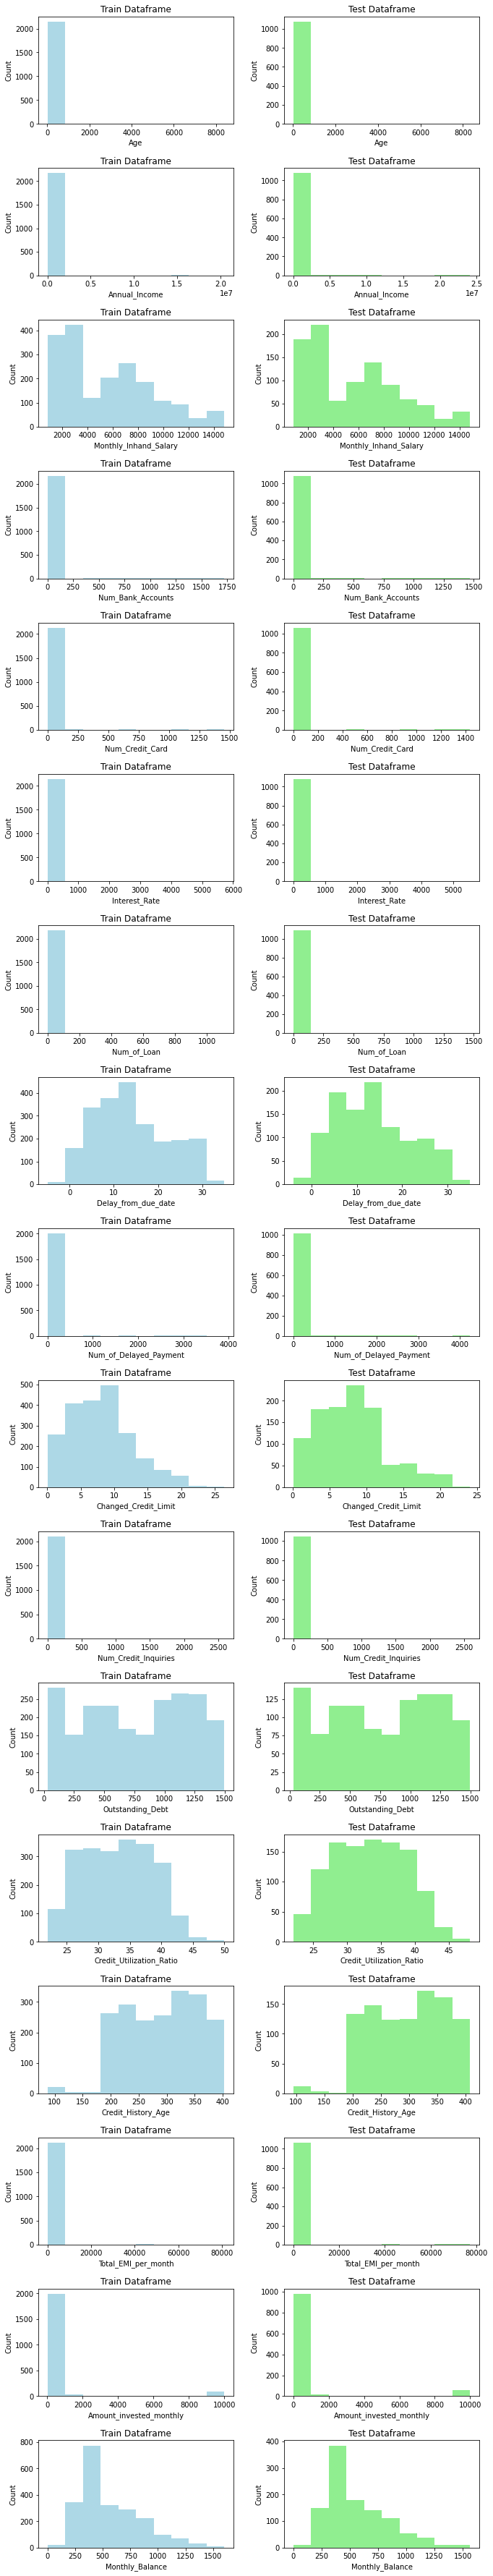

In [ ]:
# setting plot layout
fig, axes = plt.subplots(17, 2, figsize = (10, 50))
fig.tight_layout(pad = 4)

# plotting the data visualization
for i in range(len(NumFeatures)):
    axes[i, 0].hist(train[NumFeatures[i]],
                    color = 'lightblue')
    axes[i, 0].set_title('Train Dataframe')
    axes[i, 0].set_xlabel(NumFeatures[i])
    axes[i, 0].set_ylabel('Count')
    axes[i, 1].hist(test[NumFeatures[i]],
                    color = 'lightgreen')
    axes[i, 1].set_title('Test Dataframe')
    axes[i, 1].set_xlabel(NumFeatures[i])
    axes[i, 1].set_ylabel('Count')
plt.show()

### **VIb. Data Exploration Findings**<a class = "anchor" id = "VIb"></a>

Findings:
1. Monthly_Inhand_Salary, Num_of_Delayed_Payment, Changed_Credit_Limit, Num_Credit_Inquiries, Credit_History_Age, Amount_invested_monthly, and Monthly_Balance features (total: 7 features) have missing values.
2. Age, Annual_Income, Num_Bank_Accounts, Num_Credit_Card, Interest_Rate, Num_of_Loan, Num_of_Delayed_Payment, Changed_Credit_Limit, Num_Credit_Inquiries, Total_EMI_per_month, Amount_invested_monthly, and Monthly_Balance features (total: 12 features) has abnormal max value (upper outlier). These outliers should be addressed when we are filling in the missing values using mean +- stddev imputation method
3. Continuing from the Type_of_Loan feature data cleaning, the Num_of_Loan feature will need to be updated with reference to the updated value in Type_of_Loan. The Type_of_Loan feature itself will be dropped afterwards.

Important numerical data cleaning note:
In the numerical features data cleaning process, there might be cases in which each one needs a different approach. The cases:
1. Missing value in an independent entry
2. Missing value in one or more members of an aggregated entries
3. Different value in one or more members of an aggregated entries
4. Totally missing values of an aggregated entries

For example:
Customer A has 8 entries in the dataset. The Age value of this customer is either supposed to be the same in all 8 entries or differ with +1 value in the forward entries (assuming he/she might have had a birthday during the period of the data collection). However, when we are looking at the dataset, the Age values of this customer's entries show that they either have missing values or varying values. This kind of case needs to be made distinct from the other cases.

## **VII. Data Cleaning and Engineering Phase 3: Numerical Features**<a class = "anchor" id = "VII"></a>

### **VIIa. Numerical Feature: Age**<a class = "anchor" id = "VIIa"></a><a class = "anchor" id = "VIIa"></a>

The first thing we want to do with the Age feature is to get rid of the illogical values. Let us assume that the oldest people can get in this dataset and still have active credit activities are 90 years old and the youngest ones are 18 years old, based on the general legal age of 18 to be able to have a credit card. Thus, the value above 90 and below 18 will be omitted.

##### **Calculating the outlier percentage**

In [ ]:
# creating the population variable for Age 
TrainPop = len(train['Age'])
TestPop = len(test['Age'])

# Age with value larger than 90
TrainUpSample = (train['Age'] > 90).sum()
TestUpSample = (test['Age'] > 90).sum()
TrainUpPerc = TrainUpSample / TrainPop
TestUpPerc = TestUpSample / TestPop

# Age with value smaller than 18
TrainDownSample = (train['Age'] < 18).sum()
TestDownSample = (test['Age'] < 18).sum()
TrainDownPerc = TrainDownSample / TrainPop
TestDownPerc = TestDownSample / TestPop

# report
print(' Train :', '\n',
      'Age with value larger than 90  :', TrainUpSample,
      '(', TrainUpPerc, '% )', '\n',
      'Age with value smaller than 18 :', TrainDownSample,
      '(', TrainDownPerc, '% )', '\n' * 2,
      'Test :', '\n',
      'Age with value larger than 90  :', TestUpSample,
      '(', TestUpPerc, '% )', '\n',
      'Age with value smaller than 18 :', TestDownSample,
      '(', TestDownPerc, '% )')

 Train : 
 Age with value larger than 90  : 66 ( 0.006594724220623501 % ) 
 Age with value smaller than 18 : 8 ( 0.0007993605115907274 % ) 

 Test : 
 Age with value larger than 90  : 23 ( 0.004597241655006996 % ) 
 Age with value smaller than 18 : 4 ( 0.0007995202878273036 % )


##### **Dropping the outliers**

In [ ]:
# Train dataframe
NewAge = []
for i in range(len(train['Age'])):
    if train['Age'][i] > 90 or train['Age'][i] < 18:
        NewAge.append(np.nan)
    else:
        NewAge.append(train['Age'][i])       
train['Age'] = NewAge

# Test dataframe
NewAge = []
for i in range(len(test['Age'])):
    if test['Age'][i] > 90 or test['Age'][i] < 18:
        NewAge.append(np.nan)
    else:
        NewAge.append(test['Age'][i])       
test['Age'] = NewAge

##### **Filling in the missing values caused by the omission**

We are now going to fill in the missing values which appeared because of the previous omission. It is important to differ the type of missing values in this feature. Each customer has 8 entries in the dataset. These 8 entries are supposed to have the same Age value or +1 Age value in the forward entries, considering that he or she might have had a birthday during the data collection period (however, for practicality purpose, we will be assuming the same Age value in all 8 entries for one customer instead). Taking this into consideration, we can not immediately fill in all of the missing values with Age median +- standard deviation. We need to first try filling in the missing values with each customer's mode first.

In [ ]:
# creating Age lookup table, aggregated by customer ID

# creating the dataframe containing Customer_ID and Age
TrainAgeLookup = train[['Customer_ID', 'Age']]
TestAgeLookup = test[['Customer_ID', 'Age']]

# returning the Age mode of each customer
TestAgeLookup = TestAgeLookup.groupby('Customer_ID')\
                .agg(pd.Series.mode)

# replacing the Age value of each customer with each one's Mode
train['Age'] = train['Customer_ID'].map(TrainAgeLookup['Age'])
test['Age'] = test['Customer_ID'].map(TestAgeLookup['Age'])

With this replacement method, it is possible to generate Age value in type of a list for some customers. This is due to the possibility of those customers having two or three Age values which each has the same amount of occurence in their entries. We are going to eliminate these list values by using the first members of the lists instead.

##### **Eliminating any generated array-type value**

Now, we are going to eliminate any array-type value generated by the method by using only the first member of the array value.

In [ ]:
# Train dataframe
NewAge = []
for i in range(len(train['Age'])):
    # for float type members
    if type(train['Age'][i]) == np.float64:
        NewAge.append(train['Age'][i])
    # for empty list members
    elif type(train['Age'][i]) == np.ndarray and len(train['Age'][i]) == 0:
        NewAge.append(np.nan)
    # for non-empty list members
    elif type(train['Age'][i]) == np.ndarray and len(train['Age'][i]) != 0:
        NewAge.append(train['Age'][i][1])
train['Age'] = NewAge

# Test dataframe
NewAge = []
for i in range(len(test['Age'])):
    # for float type members
    if type(test['Age'][i]) == np.float64:
        NewAge.append(test['Age'][i])
    # for empty list members
    elif type(test['Age'][i]) == np.ndarray and len(test['Age'][i]) == 0:
        NewAge.append(np.nan)
    # for non-empty list members
    elif type(test['Age'][i]) == np.ndarray and len(test['Age'][i]) != 0:
        NewAge.append(test['Age'][i][1])
test['Age'] = NewAge

##### **Reconverting and rechecking the data type**

In [ ]:
# reconverting the Age feature into float
train['Age'].astype('float')
test['Age'].astype('object')

0        NaN
1        NaN
2        NaN
3        NaN
4       28.0
        ... 
4998     NaN
4999     NaN
5000     NaN
5001     NaN
5002     NaN
Name: Age, Length: 5003, dtype: object

In [ ]:
# rechecking the missing values in Age feature
remaining = train['Age'].isnull().sum()
print('Remaining Age missing values (Train):', remaining)
remaining = test['Age'].isnull().sum()
print('Remaining Age missing values (Test) :', remaining)

Remaining Age missing values (Train): 10008
Remaining Age missing values (Test) : 3910


##### **Checking the data distribution after the previous process**

For the remaining missing values present in the Age feature, we want to fill them in by referencing to a lookup table containing each ID's Age mean +- standard deviation. Before we calculate these parameters though, we need to make sure that the data distribution is distributed quite evenly, so that the parameters' values are not too off.

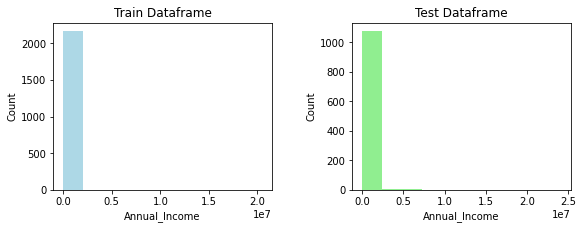

In [ ]:
# setting plot layout
fig, axes = plt.subplots(1, 2, figsize = (9, 4))
fig.tight_layout(pad = 5)

# creating histogram plots
axes[0].hist(train['Annual_Income'],
             color = 'lightblue')
axes[1].hist(test['Annual_Income'],
             color = 'lightgreen')

# setting plot information
axes[0].set_title('Train Dataframe')
axes[0].set_xlabel('Annual_Income')
axes[0].set_ylabel('Count')
axes[1].set_xlabel('Annual_Income')
axes[1].set_ylabel('Count')
axes[1].set_title('Test Dataframe')
plt.show()

##### **Creating Age lookup table containing each ID's Age mean +- std. dev.**

In [ ]:
# preparing the lookup table
TrainTable = train[['Customer_ID', 'Annual_Income']]
TestTable = test[['Customer_ID', 'Annual_Income']]

# locating the ID with empty Age value in the newly created tables
TrainID = TrainTable.loc[TrainTable['Annual_Income'].isnull(), 'Customer_ID']
TestID = TestTable.loc[TestTable['Annual_Income'].isnull(), 'Customer_ID']

# getting only the unique Customer_ID
TrainID = list(TrainID.unique())
TestID = list(TestID.unique())

# creating empty features to store Age values later
TrainAge = []
for i in range(len(TrainID)):
    TrainAge.append(np.nan)
TestAge = []
for i in range(len(TestID)):
    TestAge.append(np.nan)

# creating the Age lookup table
TrainLookup = pd.DataFrame(list(zip(TrainID, TrainAge)))
TrainLookup.columns = ['Customer_ID', 'Annual_Income']
TestLookup = pd.DataFrame(list(zip(TestID, TestAge)))
TestLookup.columns = ['Customer_ID', 'Annual_Income']

# calculating the mean value of Age feature
TrainAgeMean = train['Annual_Income'].mean()
TestAgeMean = test['Annual_Income'].mean()

# calculating the standard deviation value of Age feature
TrainAgeStdDev = train['Annual_Income'].std()
TestAgeStdDev = test['Annual_Income'].std()

# generating the Age value for the lookup table
TrainLookup['Annual_Income'] = TrainLookup['Annual_Income']\
                     .fillna(pd.Series(np.random.randint(int(TrainAgeMean - TrainAgeStdDev), 
                                                         int(TrainAgeMean + TrainAgeStdDev),
                                                         size = TrainLookup['Annual_Income'].isnull().sum())))
TestLookup['Annual_Income'] = TestLookup['Annual_Income']\
                    .fillna(pd.Series(np.random.randint(int(TestAgeMean - TestAgeStdDev), 
                                                        int(TestAgeMean + TestAgeStdDev),
                                                        size = TestLookup['Annual_Income'].isnull().sum())))

# taking a look at the lookup table
display(TrainLookup.head())
print(' TrainLookup Rows x cols :', TrainLookup.shape, '\n',
      'TestLookup Rows x cols  :', TestLookup.shape)

,Customer_ID,Annual_Income
0,NaN,672422.0


 TrainLookup Rows x cols : (1, 2) 
 TestLookup Rows x cols  : (1, 2)


In [ ]:
# filling in the missing Annual_Income values in reference to the Age lookup table
train['Annual_Income'] = train['Annual_Income']\
               .fillna(train['Customer_ID']\
                       .map(TrainLookup\
                            .set_index('Customer_ID')['Annual_Income']))
test['Annual_Income'] = test['Annual_Income']\
              .fillna(test['Customer_ID']\
                      .map(TestLookup\
                           .set_index('Customer_ID')['Annual_Income']))

# Checking if there are still missing Age values
display(train['Annual_Income'].isnull().sum())
display(test['Annual_Income'].isnull().sum())

0

0

### **VIId. Numerical Feature: Num_Bank_Accounts**<a class = "anchor" id = "VIId"></a>

By looking at the previous histogram, there exists some outliers in the Num_Bank_Accounts feature, with upper outliers the most obvious. Luckily, there are no missing values. Let's deal with the outliers first.

In [ ]:
# counting the outliers in Num_Bank_Accounts
print(' Train dataframe :')
countoutlier(train, 'Num_Bank_Accounts')
print('\n',
      'Test dataframe :')
countoutlier(test, 'Num_Bank_Accounts')

 Train dataframe :
Outlier count in Num_Bank_Accounts : 21

 Test dataframe :
Outlier count in Num_Bank_Accounts : 15


Num_Bank_Accounts  data distribution after dropping the outliers : 


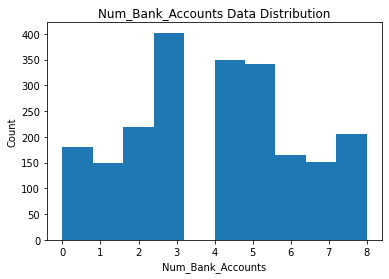

In [ ]:
# dropping the outliers in Train dataframe's Num_Bank_Accounts
omitoutlier(train, 'Num_Bank_Accounts')

Num_Bank_Accounts  data distribution after dropping the outliers : 


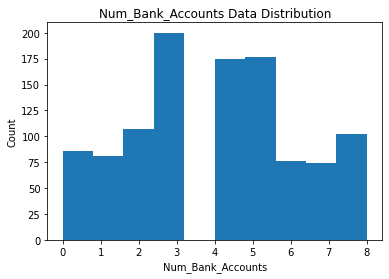

In [ ]:
# dropping the outliers in Test dataframe's Num_Bank_Accounts
omitoutlier(test, 'Num_Bank_Accounts')

### **VIIe. Numerical Feature: Num_Credit_Card**<a class = "anchor" id = "VIIe"></a>

By looking at the previous histogram, there exists some outliers in the Num_Credit_Card feature, with upper outliers the most obvious. Luckily, there are no missing values. Let's deal with the outliers first.

In [ ]:
# counting the outliers in Num_Credit_Card
print(' Train dataframe :')
countoutlier(train, 'Num_Credit_Card')
print('\n',
      'Test dataframe :')
countoutlier(test, 'Num_Credit_Card')

 Train dataframe :
Outlier count in Num_Credit_Card : 54

 Test dataframe :
Outlier count in Num_Credit_Card : 34


Num_Credit_Card  data distribution after dropping the outliers : 


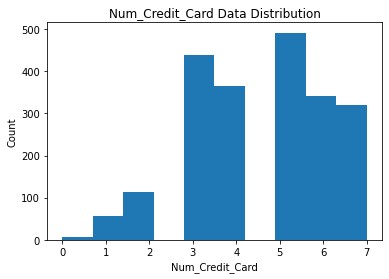

In [ ]:
# dropping the outliers in Train dataframe's Num_Credit_Card
omitoutlier(train, 'Num_Credit_Card')

Num_Credit_Card  data distribution after dropping the outliers : 


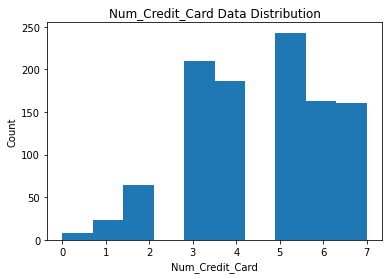

In [ ]:
# dropping the outliers in Test dataframe's Num_Credit_Card
omitoutlier(test, 'Num_Credit_Card')

The data distribution looks nice. Since the Num_Credit_Card values per customer share a same value, we will be dealing with this feature using the defined lookupreplacement and aggregatedfillna functions.

### **VIIf. Numerical Feature: Interest_Rate**<a class = "anchor" id = "VIIf"></a>

By looking at the previous histogram, there exists some outliers in the Interest_Rate feature, with upper outliers the most obvious. Luckily, there are no missing values. Let's deal with the outliers first.

In [ ]:
# counting the outliers in Interest_Rate
print(' Train dataframe :')
countoutlier(train, 'Interest_Rate')
print('\n',
      'Test dataframe :')
countoutlier(test, 'Interest_Rate')

 Train dataframe :
Outlier count in Interest_Rate : 49

 Test dataframe :
Outlier count in Interest_Rate : 17


Interest_Rate  data distribution after dropping the outliers : 


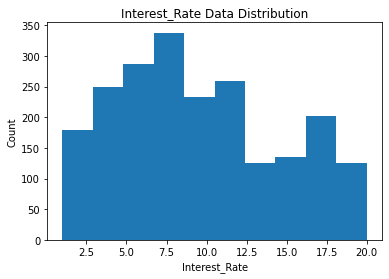

In [ ]:
# dropping the outliers in Train dataframe's Interest_Rate
omitoutlier(train, 'Interest_Rate')

Interest_Rate  data distribution after dropping the outliers : 


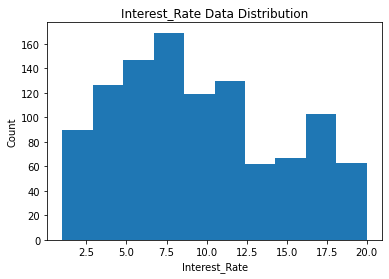

In [ ]:
# dropping the outliers in Test dataframe's Interest_Rate
omitoutlier(test, 'Interest_Rate')

The data distribution looks nice. Since the Interest_Rate values per customer share a same value, we will be dealing with this feature using the defined lookupreplacement and aggregatedfillna functions.

In [ ]:
# replacing the Interest_Rate value of each customer using each customer's Interest_Rate Mode
print('Train dataframe :')
lookupreplacement(train, 'Customer_ID', 'Interest_Rate')
print('\n',
      'Test dataframe :')
lookupreplacement(test, 'Customer_ID', 'Interest_Rate')

Train dataframe :
Remaining Interest_Rate missing values : 7822

 Test dataframe :
Remaining Interest_Rate missing values : 3910


There are no remaining missing values after the lookupreplacement operation, so we will proceed with the next numerical feature.

# **Part 2: Classification Model Building**<a class = "anchor" id = "Part_2"></a>

The output expected from the machine learning models in this project is to determine a customer's credit score based on various data possessed by the customer as the inputs. Thus, the nature of the models that will be built can be categorized as classification models, which are supervised models to classify what credit score will emerge based on various features as the inputs. Some of the most practical and most used classification models, but not limited to them are Decision Tree, Random Forest, Support Vector Machine, Neural Network, Logistic Regression, K-Nearest Neighbors, and Naive-Bayes models. Each of these models behaves differently and thus each has different compatible type of data to work with. That is why we are also going to do some exploratory data analysis on the dataframe to better understand the nature of the data present in each feature, then do some feature engineering to satisfy the input condition for each models if needed. After building the initial models, they are then going to be scored and optimized by doing some parameter tuning until good models are developed through this process. Lastly, the best model is going to be used to classify the last four months' Credit_Score for each customer in the Test dataset.

## **VIII. Data Exploration Phase 4**<a class = "anchor" id = "VIII"></a>

First of all, we are going to look deeper at the dataframe to learn the nature and correlation of each feature that are present in the dataframe. By doing so, we are supposed to get a better understanding of the dataframe and thus will be able to more accurately determine what machine learning to use and which features to be selected as the input for each machine learning.

### **VIIIa. General Overview**<a class = "anchor" id = "VIIIa"></a>

In [ ]:
# rechecking the general overview of the Train dataframe
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        10008 non-null  object 
 1   Customer_ID               2186 non-null   object 
 2   Month                     2186 non-null   object 
 3   Age                       0 non-null      float64
 4   SSN                       2186 non-null   object 
 5   Occupation                2186 non-null   object 
 6   Annual_Income             10008 non-null  float64
 7   Monthly_Inhand_Salary     2186 non-null   float64
 8   Num_Bank_Accounts         2186 non-null   object 
 9   Num_Credit_Card           2186 non-null   object 
 10  Interest_Rate             2186 non-null   float64
 11  Num_of_Loan               2186 non-null   float64
 12  Type_of_Loan              10008 non-null  object 
 13  Delay_from_due_date       2186 non-null   float64
 14  Num_of

None

In [ ]:
# rechecking the general overview of the Test dataframe
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5003 entries, 0 to 5002
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        5003 non-null   object 
 1   Customer_ID               1093 non-null   object 
 2   Month                     1093 non-null   object 
 3   Age                       1093 non-null   object 
 4   SSN                       1093 non-null   object 
 5   Occupation                1093 non-null   object 
 6   Annual_Income             5003 non-null   float64
 7   Monthly_Inhand_Salary     1093 non-null   object 
 8   Num_Bank_Accounts         1078 non-null   float64
 9   Num_Credit_Card           1059 non-null   float64
 10  Interest_Rate             1093 non-null   float64
 11  Num_of_Loan               1093 non-null   float64
 12  Type_of_Loan              5003 non-null   object 
 13  Delay_from_due_date       1093 non-null   float64
 14  Num_of_D

None

We are now going to store the features present in both dataframes into different lists based on the type of data each feature contain for further use in analysis.

##### **Storing features based on each feature's data type**

In [ ]:
# train numerical features
trainNum = []
for col in train.columns:
    if train[col].dtype == ('float64') or train[col].dtype == ('int64'):
        trainNum.append(col)

# test numerical features
testNum = []
for col in test.columns:
    if test[col].dtype == ('float64') or test[col].dtype == ('int64'):
        testNum.append(col)
        
# train categorical features
trainCat = []
for col in train.columns:
    if train[col].dtype == ('object'):
        trainCat.append(col)

# test categorical features
testCat = []
for col in test.columns:
    if test[col].dtype == ('object'):
        testCat.append(col)
        
# train boolean features
trainBool = []
for col in test.columns:
    if train[col].dtype == ('bool'):
        trainBool.append(col)

# test boolean features
testBool = []
for col in test.columns:
    if test[col].dtype == ('bool'):
        testBool.append(col)

For the categorical features, there are some features that do not mean much for analysis, such as ID, Customer_ID, and SSN, as they mainly serve only as identifiers for the customers. We are going to further categorize only the categorical features that will be used for the machine learning building.

In [ ]:
# categorical features to drop
CatDrop = ['ID', 'Customer_ID', 'SSN']

# dropping the categorical features from trainCat
for feature in CatDrop:
    trainCat.remove(feature)
    testCat.remove(feature)

### **VIIIb. Univariate Analysis**<a class = "anchor" id = "VIIIb"></a>

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_axes.py:6630: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_axes.py:6631: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: ignored

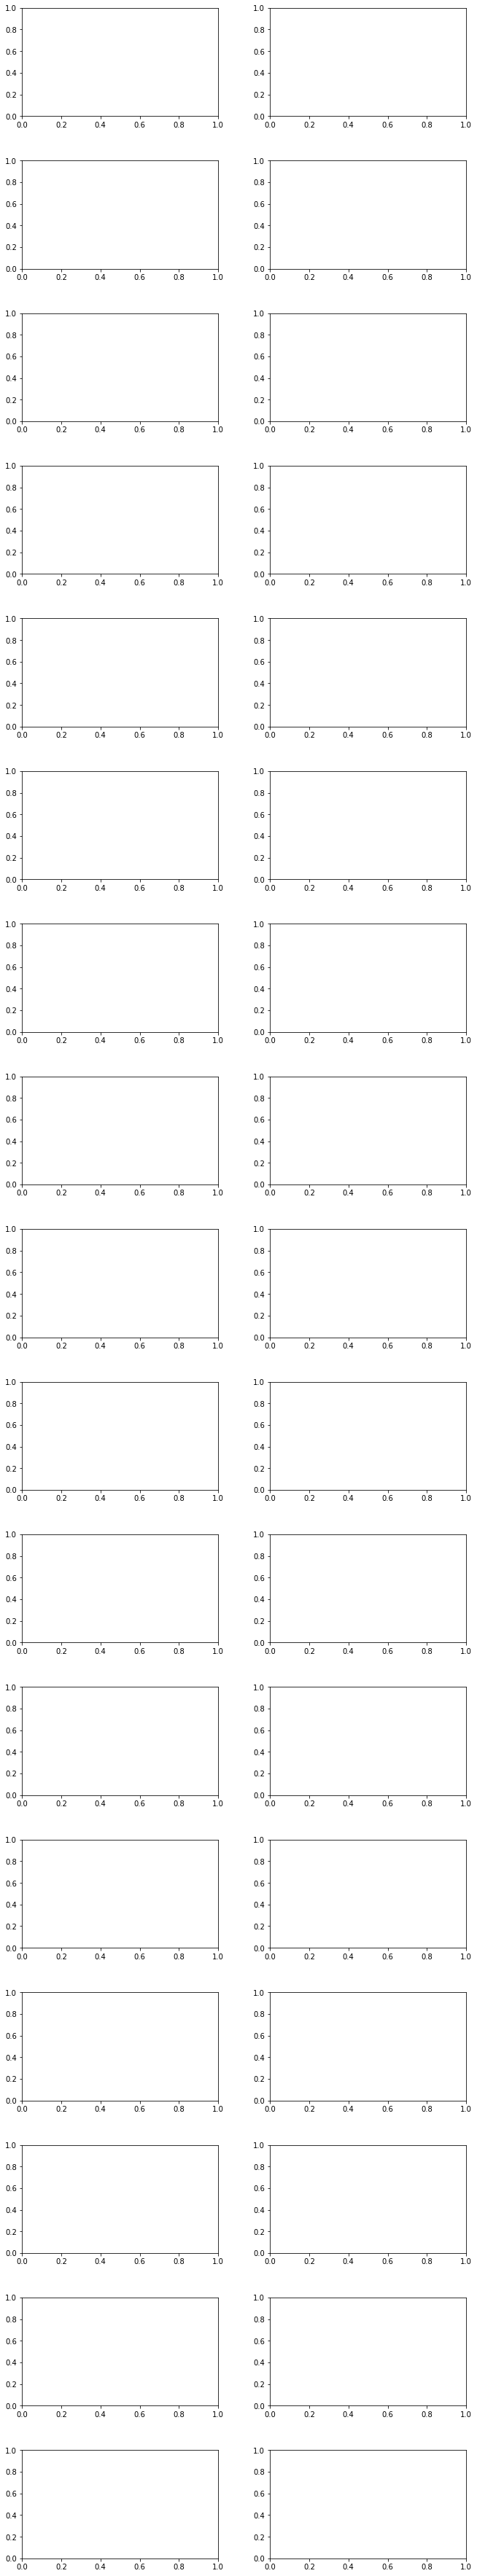

In [ ]:
# setting plot layout
fig, axes = plt.subplots(17, 2, figsize = (10, 50))
fig.tight_layout(pad = 4)

# plotting the data visualization
for i in range(len(NumFeatures)):
    axes[i, 0].hist(train[NumFeatures[i]],
                    color = 'lightblue')
    axes[i, 0].set_title('Train Dataframe')
    axes[i, 0].set_xlabel(NumFeatures[i])
    axes[i, 0].set_ylabel('Count')
    axes[i, 1].hist(test[NumFeatures[i]],
                    color = 'lightgreen')
    axes[i, 1].set_title('Test Dataframe')
    axes[i, 1].set_xlabel(NumFeatures[i])
    axes[i, 1].set_ylabel('Count')
plt.show()

There are no missing values and no notable extreme outliers present in both dataframes, as we have cleaned them in the previous steps. Also, in each numerical features, both train and test datasets show a very similar data distrbution. After looking at the above histograms, we can gather the data distribution of each numerical feature.

##### **Histogram Skewness**

In [ ]:
# creating empty lists to store skewness numbers
listTrainSkewNum = []
listTrainSkewness = []
listTestSkewNum = []
listTestSkewness = []

# data distribution shape
DataDistModality = ['bimodal', 'unimodal', 'unimodal',
                    'unimodal', 'unimodal', 'unimodal',
                    'unimodal', 'bimodal', 'unimodal',
                    'multimodal', 'unimodal', 'unimodal',
                    'unimodal', 'unimodal', 'unimodal',
                    'unimodal', 'bimodal']

# skewness
for trainfeature, testfeature in zip(trainNum, testNum):
    # for train numerical features
    trainSkew = train[trainfeature].skew()
    listTrainSkewNum.append(trainSkew)
    if trainSkew >= 1:
        trainSkewness = 'highly right-skewed'
    elif trainSkew <= -1:
        trainSkewness = 'highly left-skewed'
    elif trainSkew < 1 and trainSkew >= 0.5:
        trainSkewness = 'moderately right-skewed'
    elif trainSkew > -1 and trainSkew <= -0.5:
        trainSkewness = 'moderately left-skewed'
    else:
        trainSkewness = 'symmetrical'
    listTrainSkewness.append(trainSkewness)
    
    # for test numerical features
    testSkew = test[testfeature].skew()
    listTestSkewNum.append(testSkew)
    if testSkew >= 1:
        testSkewness = 'highly right-skewed'
    elif testSkew <= -1:
        testSkewness = 'highly left-skewed'
    elif testSkew < 1 and testSkew >= 0.5:
        testSkewness = 'moderately right-skewed'
    elif testSkew > -1 and testSkew <= -0.5:
        testSkewness = 'moderately left-skewed'
    else:
        testSkewness = 'symmetrical'
    listTestSkewness.append(testSkewness)
    
# numerical features data distribution report
SkewnessTable = pd.DataFrame(list(zip(trainNum, DataDistModality, listTrainSkewNum, listTrainSkewness,
                                      listTestSkewNum, listTestSkewness)))
SkewnessTable.columns = ('Feature', 'Data Distribution Modality', 'Train Skew Number', 'Train Skewness',
                         'Test Skew Number', 'Test Skewness')

# displaying the skewness table
SkewnessTable

### **VIIIc. Bivariate Analysis**<a class = "anchor" id = "VIIIc"></a>

Bivariate analysis is an analysis between two variables or features in a dataset. We are essentially going to do the the analysis on the Credit_Score feature, which is the output of this project. All the other features are going to be visualized against the output feature. Box plots will be used as the visualization tool for numerical data, while Count Plot for categorical data.

#### **a. Numerical Features vs. Credit_Score**<a class = "anchor" id = "VIIIc_a"></a>

In [ ]:
# creating figure
fig, axes = plt.subplots(6, 3, figsize = (15, 30))
fig.tight_layout(pad = 5)

# start of moving parameter for the subplot positions
setstart = 0
setstop = 3
row = 0
cols = [0, 1, 2]

# plotting the box plots
while row < 6: 
    for feature, col in zip(trainNum[setstart:setstop], cols):
        sns.boxplot(x = train['Credit_Score'], 
                    y = train[feature], 
                    ax = axes[row, col], 
                    palette = 'Blues').set(title = 'train: ' + feature + ' Box Plot')
    setstart = setstart + 3
    setstop = setstop + 3
    row = row + 1
plt.show()

#### **b. Boolean Features vs. Credit_Score**<a class = "anchor" id = "VIIIc_b"></a>

In [ ]:
# creating figure
fig, axes = plt.subplots(3, 3, figsize = (15, 15))
fig.tight_layout(pad = 5)

# start of moving parameter for the subplot positions
setstart = 0
setstop = 3
row = 0
cols = [0, 1, 2]

# plotting the count plots
while row < 3: 
    for feature, col in zip(trainBool[setstart:setstop], cols):
        sns.countplot(x = train['Credit_Score'], 
                      hue = train[feature], 
                      ax = axes[row, col], 
                      palette = 'Blues').set(title = 'train: ' + feature + ' Count Plot')
    setstart = setstart + 3
    setstop = setstop + 3
    row = row + 1
plt.show()

#### **c. Ordinal and Nominal Categorical Features vs. Credit_Score**<a class = "anchor" id = "VIIIc_c"></a>

In [ ]:
# creating figure
fig, axes = plt.subplots(6, 1 , figsize = (20, 40))
fig.tight_layout(pad = 5)

# plotting the count plots
row = 0
for feature in trainCat:
    sns.countplot(x = train[feature],
                 hue = train['Credit_Score'],
                 ax = axes[row],
                 palette = 'Blues').set(title = 'train: ' + feature + ' Count Plot')
    row = row + 1

## **IX. Features Selection**<a class = "anchor" id = "IX"></a>

Before building all the machine learning models, we first need to select some subsets of features to use as the inputs for each model. The purpose of this selection is to reduce the time needed for the models to compute and also in most cases to increase the accuracy of the models themselves. This is due to the different nature of each model, for example some are better suited to compute numerical data as the input, while others are better at handling categorical data. We will elaborate the input selection for the model building further.

##### **Features selection method**

In [ ]:
# defining the input, output, and methods used for the feature selection process
listinput = ['numerical (normal)', 'numerical (skewed)', 'categorical', 'boolean']
listoutput = [['categorical'], ['categorical'], ['categorical'], ['categorical']]
listmethod = [['ANOVA', 'Pearson'], 
              ["Kendall's Tau", 'Pearson'], 
              ['Chi-Squared', 'Mutual Information'],
              ['Mutual Information']]

# creating feature selection method table
MultVarAnalysisMethod = pd.DataFrame({'Input': listinput, 'Output': listoutput, 'Method': listmethod})
display(MultVarAnalysisMethod)

### **IXa. Dataframe Engineering and Features Selection Preparation**<a class = "anchor" id = "IXa"></a>

Before conducting the feature selection process, let's do some engineering to the Train dataframe to make it easier to process.

In [ ]:
# dropping the ID, Customer_ID, and SSN features from Train dataframe
for feature in CatDrop:
    train.drop(feature, axis = 1, inplace = True)

In [ ]:
# appending Credit_Score feature into trainNum to include the output feature
trainNum.append('Credit_Score')

In [ ]:
# input features of train
trainInput = train[train.columns[:-1]]

# output feature of train
trainOutput = train[train.columns[-1]]

##### **Encoding string items**

In [ ]:
# encoding the categorical value in Train dataframe
for feature in trainCat[:-1]: # Credit_Score needs to be separated as it will be inversed to its original in the end
    train[feature] = enc.fit_transform(train[feature])

# encoding and storing the Credit_Score feature
encCredit_Score = enc.fit_transform(train['Credit_Score'])
train['Credit_Score'] = encCredit_Score

In [ ]:
# encoding, and transforming the Credit_Score feature
enc.fit(train['Credit_Score'])
classes = list(enc.classes_)
codes = list(enc.transform(list(enc.classes_)))
encCredit_Score = pd.DataFrame(list(zip(classes, codes)))
encCredit_Score.columns = ('Classes', 'Codes')
DictCredit_Score = dict(list(enumerate(encCredit_Score['Classes'])))
train['Credit_Score'] = enc.transform(train['Credit_Score'])

In [ ]:
# mapping the boolean categorical feature into a numerical form
for feature in trainBool:
    train[feature] = enc.fit_transform(train[feature])

##### **Separating numerical features with normal and not normal data distribution**

For the numerical input with **normal data distribution**, ANOVA method will be used. For the numerical input with **skewed, bimodal, and/or multimodal data distribution**, Kendall's Tau method will be used.

In [ ]:
# storing the numerical features with normal data distribution
trainNumNormal = SkewnessTable['Feature'][SkewnessTable['Data Distribution Modality'] == 'unimodal'][SkewnessTable['Train Skewness'] == 'symmetrical']
trainNumNormal

In [ ]:
# storing the numerical features with non-normal data distribution
normalindex = trainNumNormal.index
trainNumNotNormal = SkewnessTable['Feature'].drop(normalindex, axis = 0)
trainNumNotNormal

### **IXb. Pearson Correlation**<a class = "anchor" id = "IXb"></a>

In this method, we will gather the features which have a rather high correlation coefficient with the Credit_Score feature. As a rule of thumb, the condition for a feature to be assumed having a strong correlation is if its correlation coefficient is higher than 0.7

##### **Categorical features correlation to Credit_Score**

In [ ]:
# setting up the figure
plt.figure(figsize = (10, 8))

# creating the correlation heatmap
sns.heatmap(train[trainCat].corr(),
           annot = True,
           linewidths = 0.1,
           cmap = 'Blues')
plt.title('Categorical Features Correlation to Credit_Score')
plt.show()

##### **Numerical features correaltion to Credit_Score**

In [ ]:
# setting up the figure
plt.figure(figsize = (20, 18))

# creating the correlation heatmap
sns.heatmap(train[trainNum].corr(),
           annot = True,
           linewidths = 0.1,
           cmap = 'Blues')
plt.title('Numerical Features Correlation to Credit_Score')
plt.show()

From both correlation heatmaps above, it is gathered that none of the input features have strong correlation with the output feature Credit_Score. This might be due to Credit_Score initially being a categorical feature. We will proceed with the other feature selection methods.

### **IXc. ANOVA F-Score**<a class = "anchor" id = "IXc"></a>

In [ ]:
# setting the model to calculate correlation value using ANOVA
fs = SelectKBest(score_func = f_classif, 
                 k = 'all')

# fitting the input and output into the model
fsinput = train[trainNumNormal] # numerical features with normal distribution
fsresponse = train['Credit_Score']
fs.fit(fsinput, fsresponse)

# creating ANOVA report table
ANOVAreport = pd.DataFrame({'Feature': trainNumNormal, 'f-score': fs.scores_, 'p-value': fs.pvalues_})
display(ANOVAreport)

# displaying the ANOVA f-scores and their corresponding p-values in bar plots
fig, axes = plt.subplots(2, figsize = (10, 10))
fig.tight_layout(pad = 3)
# ANOVA f-scores
axes[0].bar(ANOVAreport['Feature'],
            ANOVAreport['f-score'],
            color = 'lightblue')
axes[0].set_title('Train Dataset - Numerical Features with Normal Data Distribution - ANOVA f-score')
# corresponding p-values
axes[1].bar(ANOVAreport['Feature'],
            ANOVAreport['p-value'],
            color = 'lightblue')
axes[1].set_title('Train Dataset - Numerical Features with Normal Data Distribution - ANOVA p-value')
plt.show()

From the report, it can be seen that the Num_Bank_Accounts, Num_Credit_Card, Interest_Rate, and Credit_History_Age features have high ANOVA F-scores. It basically means that choosing different data group sample variation in each feature has a relatively considerable impact to the output feature. We can say that these features have some sort of correlation to the Credit_Score output feature and will be used as a subset of features as the input for the later model building. Moreover, the p-values of these features are also small (below .05), indicating a variable means of each different sample.

In [ ]:
# feature subset obtained from ANOVA
fsubsetANOVA = ['Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Credit_History_Age']

### **IXd. Kendall's Tau**<a class = "anchor" id = "IXd"></a>

In [ ]:
# creating list for storing Kendall's Tau and each corresponding p-values
listtau = []
listpvalue = []
for feature in trainNumNotNormal:
    tau, p_value = kendalltau(train[feature], train['Credit_Score'])
    listtau.append(tau)
    listpvalue.append(p_value)

# creating Kendall's Tau report table
kendallreport = pd.DataFrame({'Feature': trainNumNotNormal, "Kendall's Tau": listtau, 'p-value': listpvalue})
display(kendallreport)

# displaying the Kendall's Tau and corresponding p-values in horizontal bar plots
fig, axes = plt.subplots(2, figsize = (10,10))
fig.tight_layout(pad = 3)
# Kendall's Tau
axes[0].barh(kendallreport['Feature'],
            kendallreport["Kendall's Tau"],
            color = 'lightblue')
axes[0].set_title("Train Dataset - Numerical Features with Non-Normal Data Distribution - Kendall's Tau")
# Corresponding p-values
axes[1].barh(kendallreport['Feature'],
            kendallreport['p-value'],
            color = 'lightblue')
axes[1].set_title("Train Dataset - Numerical Features with Non-Normal Data Distribution - p-value")

plt.show()

From the Kendall's Tau report, there seems that there are no features with strong correlation to the output feature Credit_Score. However, we will still try using the two strongest features compared to the other ones, that are Changed_Credit_Limit and Num_of_Delayed_Payment features. These two features have moderately strong correlation to Credit_Score, with Kendall's Tau over .10. These features also have small p-values (below .05), which indicate different mean values for each sample group.

In [ ]:
# feature subset obtained from Kendall's Tau
fsubsetKendall = ['Changed_Credit_Limit', 'Num_of_Delayed_Payment']

### **IXe. Chi-Squared**<a class = "anchor" id = "IXe"></a>

##### **Ordinal and nominal categorical data**

In [ ]:
# setting the model to calculate correlation value using Chi-Squared
chi2 = SelectKBest(score_func = chi2, 
                  k = 'all')

# fitting the input and output into the model
chi2input = train[trainCat[:-1]]
chi2response = train['Credit_Score']
chi2.fit(chi2input, chi2response)

# creating Chi-Squared report table
chi2report = pd.DataFrame({'Feature': trainCat[:-1], 'Chi-Squared': chi2.scores_, 'p-value': chi2.pvalues_})
display(chi2report)

# displaying the Chi-Squared values and their corresponding p-values in bar plots
fig, axes = plt.subplots(2, figsize = (10, 10))
fig.tight_layout(pad = 3)
# Chi-Squared
axes[0].bar(chi2report['Feature'],
            chi2report['Chi-Squared'],
            color = 'lightblue')
axes[0].set_title('Train Dataset - Categorical Features - Chi-Squared')
# corresponding p-values
axes[1].bar(chi2report['Feature'],
            chi2report['p-value'],
            color = 'lightblue')
axes[1].set_title('Train Dataset - Categorical Features - p-value')
plt.show()

From the Chi-Squared report, the Credit_Mix, Payment_of_Min_Amount, and Payment_Behaviour features show higher Chi-Squared values compared to the other two categorical values. In short, high Chi-Squared values basically means that the response is dependent to the features being measured. The low corresponding p-values (below .05) also support this result.

In [ ]:
# feature subset obtained from Chi-Squared
fsubsetChi = ['Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']

### **IXf. Mutual Information**<a class = "anchor" id = "IXf"></a>

##### **Ordinal and nominal categorical data**

In [ ]:
# setting the model to calculate correlation value using Mutual Information
MI = SelectKBest(score_func = mutual_info_classif, 
                k = 'all')

# fitting the input and output into the model
MIinput = train[trainCat[:-1]]
MIresponse = train['Credit_Score']
MI.fit(MIinput, MIresponse)

# creating Mutual Information report table
MIreport = pd.DataFrame({'Feature': trainCat[:-1], 'Mutual Information': MI.scores_})
display(MIreport)

# displaying the Mutual Information values and their corresponding p-values in bar plots
fig = plt.subplots(figsize = (12, 7))
plt.bar(MIreport['Feature'],
       MIreport['Mutual Information'],
       color = 'lightblue')
plt.title('Train Dataset - Categorical Features - Mutual Information f-score')
plt.show()

From the Mutual Information report, the Credit_Mix and Payment_of_Min_Amount features show higher Mutual Information values compared to the other three categorical values. Higher Mutual Information values basically means that the feature and response are dependent of each other. In this method, there are no p values like in the previous methods.

In [ ]:
# feature subset obtained from Chi-Squared
fsubsetMI = ['Credit_Mix', 'Payment_of_Min_Amount']

##### **Boolean categorical data**

In [ ]:
# setting the model to calculate correlation value using Mutual Information
MI = SelectKBest(score_func = mutual_info_classif, 
                k = 'all')

# fitting the input and output into the model
MIinput = train[trainBool]
MIresponse = train['Credit_Score']
MI.fit(MIinput, MIresponse)

# creating Mutual Information report table
MIreport = pd.DataFrame({'Feature': trainBool, 'Mutual Information': MI.scores_})
display(MIreport)

# displaying the Mutual Information values and their corresponding p-values in bar plots
fig = plt.subplots(figsize = (22, 10))
plt.bar(MIreport['Feature'],
       MIreport['Mutual Information'],
       color = 'lightblue')
plt.title('Train Dataset - Categorical Features - Mutual Information f-score')
plt.show()

From the Mutual Information report, there are no boolean feature that has strong or moderate correlation to the output feature Credit_Score. Therefore, we will not be using these features for the machine learning models building independently, but instead using them altogether.

### **IXg. Subset of Best-Correlating Features**<a class = "anchor" id = "IXg"></a>

From our previous steps, we gathered some subsets of features, whose correlation to the **Credit_Score** feature are better compared to the other ones. Let's recap those subset of features.

In [ ]:
# numerical data with normal data distribution
print(colored('fsubsetANOVA', attrs = ['bold']))
print('Best-correlating numerical features with normal data distribution obtain by ANOVA method:', '\n', fsubsetANOVA, '\n')

# numerical data with non-normal data distribution
print(colored('fsubsetKendall', attrs = ['bold']))
print('Best-correlating numerical features with non-normal data distribution obtained by Kendall method:', '\n', fsubsetKendall, '\n')

# categorical data using Chi-Squared
print(colored('fsubsetChi', attrs = ['bold']))
print('Best-correlating categorical features obtained by Chi-Squared method :', '\n', fsubsetChi, '\n')

# categorical data using Mutual Information
print(colored('fsubsetMI', attrs = ['bold']))
print('Best-correlating categorical features obtained by Mutual Information method :', '\n', fsubsetMI, '\n')

# joining best correlating features into a single list
fsubsetNumCat = fsubsetANOVA + fsubsetKendall + fsubsetChi
print(colored('fsubsetNumCat', attrs = ['bold']))
print('All best-correlating numerical and non-boolean categorical features :', '\n', fsubsetNumCat, '\n')

# boolean features
fsubsetBool = (train.columns[22:-1]).tolist()
print(colored('fsubsetBool', attrs = ['bold']))
print('Boolean features :', '\n', fsubsetBool, '\n')

# joining the best correlating features and including boolean features in them
fsubsetComplete = fsubsetNumCat + fsubsetBool
print(colored('fsubsetComplete', attrs = ['bold']))
print('All best-correlating features including boolean categorical features:', '\n', fsubsetComplete)

## **X. Machine Learning Models**<a class = "anchor" id = "X"></a>

### **Xa. Train Dataframe Splitting**<a class = "anchor" id = "Xa"></a>

In this project, we indeed have a pair of Train and Test dataframes. However, since the Test dataframe here does not have the output feature to validate the accuracy of the machine learning models, we need to further split the Train dataframe into a Sub-Train dataframe and its Sub-Test dataframe counterpart. This way, this later pair can give us the chance to gauge the accuracy of the models that will be built. One important note when splitting the Train dataframe is to apply a stratification to the output feature Credit_Score, so that each class in this feature has the same proportion both in Sub-Train and Sub-Test dataframes.

##### **Splitting the Train dataframe**

In [ ]:
# splitting the train into subtrain and subtest
subtrain, subtest = train_test_split(train,
                                     test_size = 0.33,
                                     stratify = train['Credit_Score'])

ValueError: ignored

In [ ]:
# checking the size of subtrain and subtest datasets
print('Subtrain dataframe rows x cols :', subtrain.shape)
print('Subtest dataframe rows x cols  :', subtest.shape)

NameError: ignored

##### **Checking the proportion of each class in Credit_Score**

In [ ]:
# getting the unique value in Credit_Score for subtrain dataset
listCreditScore = subtrain['Credit_Score'].unique()

# getting the count of each unique value for subtrain dataset
listcount = []
for CreditScore in listCreditScore:
    count = (subtrain['Credit_Score'] == CreditScore).sum()
    listcount.append(count)

# getting the percentage of each unique value for subtrain dataset
listcountperc = []
for CreditScore in listCreditScore:
    perc = (subtrain['Credit_Score'] == CreditScore).sum() / len(subtrain['Credit_Score'])
    listcountperc.append(perc)
    
# creating split report for subtrain dataset
splitreporttrain = pd.DataFrame({'Class': subtrain['Credit_Score'].unique(),
                                'Count': listcount,
                                'Percentage': listcountperc})

# displaying the split report for subtrain
print('Subtrain Credit_Score class proportions')
display(splitreporttrain.sort_values('Class'))
print('\n')

# getting the unique value in Credit_Score for subtest dataset
listCreditScore = subtest['Credit_Score'].unique()

# getting the count of each unique value for subtest dataset
listcount = []
for CreditScore in listCreditScore:
    count = (subtest['Credit_Score'] == CreditScore).sum()
    listcount.append(count)

# getting the percentage of each unique value for subtest dataset
listcountperc = []
for CreditScore in listCreditScore:
    perc = (subtest['Credit_Score'] == CreditScore).sum() / len(subtest['Credit_Score'])
    listcountperc.append(perc)
    
# creating split report for subtrain dataset
splitreporttest = pd.DataFrame({'Class': subtest['Credit_Score'].unique(),
                                'Count': listcount,
                                'Percentage': listcountperc})

# displaying the split report for subtrain
print('Subtest Credit_Score class proportions')
display(splitreporttest.sort_values('Class'))

**The Credit_Score class proportions is the same for both Subtrain and Subtest dataframes**. The shape of each dataframe also tells that the split has been done successfully. Let's now separate the output feature from the input features on both dataframes.

##### **Splitting input and output features**

In [ ]:
# subtrain
X_subtrain = subtrain[subtrain.columns[:-1]] # input features
y_subtrain = subtrain[subtrain.columns[-1]]  # output feature

# subtest
X_subtest = subtest[subtest.columns[:-1]] # input features
y_subtest = subtest[subtest.columns[-1]]  # output feature

### **Xb. Random Forest**<a class = "anchor" id = "Xb"></a>

#### **a. Subset of Parameters**<a class = "anchor" id = "Xb_a"></a>

In the Random Forest model, there are some important parameters that need to be set. The parameters that will be set are as follow:
*   **criterion** : The function to measure the quality of a split
*   **min_sample_leaf** : The minimum number of samples required to split an internal node
*   **n_estimator** : The number of trees in the forest
*   **max_features** : The number of features to consider when looking for the best split
*   **max_depth** : The maximum depth of the tree

In [ ]:
# criterion
criterion = ['gini', 'entropy']

# min_sample leaf
min_sample_leaf = [1, 2, 4]

# n_estimator
n_estimator = [64, 128]

# max_features
max_features = ['sqrt', 'log2']

# max_depth
max_depth = []
for i in range (0, 10, 3):
    max_depth.append(i)
max_depth.append(None)
max_depth.pop(0)

# assigning the parameters into a parameter grid
parameter_grid = {'criterion': criterion,
                 'min_samples_leaf': min_sample_leaf,
                 'n_estimators': n_estimator,
                 'max_features': max_features,
                 'max_depth': max_depth}

# displaying the parameters
print(colored('Random Forest', attrs = ['bold']), 'parameters :')
parameter_grid

#### **b. Model Input: Best Correlating Numerical and Categorical Features**<a class = "anchor" id = "Xb_b"></a>

##### **Choosing the best parameter values**

In [ ]:
# the machine learning model that will be used
rf = RandomForestClassifier()

In [ ]:
# assigning the parameter grid into the model
RFNumCat = GridSearchCV(estimator = rf,
                        param_grid = parameter_grid,
                        n_jobs = 8,
                        cv = 3,
                        verbose = -1)

# assigning the data from Subtrain dataframe into the model
RFNumCat.fit(X_subtrain[fsubsetNumCat], y_subtrain)

In [ ]:
# best subset of parameters obtained from Grid Search CV
print('Best subset of parameters obtained from GridSearchCV for the fsubsetNumCat input :')
RFNumCatBestParam = RFNumCat.best_params_
RFNumCatBestParam

In [ ]:
RFNumCatBestParam['criterion']

In [ ]:
# setting up the model
RFClassifier = RandomForestClassifier(**RFNumCatBestParam)

# fitting the data from Subtrain dataframe into the model
RFClassifier.fit(X_subtrain[fsubsetNumCat], y_subtrain)

# predicting the Credit_Score in Subtest dataframe
RFNumCatPred = RFClassifier.predict(X_subtest[fsubsetNumCat])

# getting the accuracy of the model
RFNumCatAcc = accuracy_score(y_subtest, RFNumCatPred)

# model accuracy report
print('Subset of features : fsubsetNumCat')
print('Random Forest Classifier model accuracy: {:.2f}%'.format(RFNumCatAcc*100))

#### **c. Model Input: Best Correlating Numerical Features with Normal Data Distribution**<a class = "anchor" id = "Xb_c"></a>

In [ ]:
# assigning the parameter grid into the model
RFANOVA = GridSearchCV(estimator = rf,
                       param_grid = parameter_grid,
                       n_jobs = 8,
                       cv = 3,
                       verbose = -1)

# assigning the data from Subtrain dataframe into the model
RFANOVA.fit(X_subtrain[fsubsetANOVA], y_subtrain)

In [ ]:
# best subset of parameters obtained from Grid Search CV
print('Best subset of parameters obtained from GridSearchCV for the fsubsetANOVA input :')
RFANOVABestParam = RFANOVA.best_params_
RFANOVABestParam

In [ ]:
# setting up the model using the best subset of parameters
RFClassifier = RandomForestClassifier(**RFANOVABestParam)

# fitting the data from Subtrain dataframe into the model
RFClassifier.fit(X_subtrain[fsubsetANOVA], y_subtrain)

# predicting the Credit_score in Subtest dataframe
RFANOVApred = RFClassifier.predict(X_subtest[fsubsetANOVA])

# getting the accuracy of the model
RFANOVAAcc = accuracy_score(y_subtest, RFANOVApred)

# model accuracy report
print('Subset of features : fsubsetANOVA')
print('Random Forest Classifier model accuracy: {:.2f}%'.format(RFANOVAAcc*100))

#### **d. Input: Best Correlating Numerical Features with Non-Normal Data Distribution**<a class = "anchor" id = "Xb_d"></a>

In [ ]:
# assigning the parameter grid into the model
RFKendall = GridSearchCV(estimator = rf,
                         param_grid = parameter_grid,
                         n_jobs = 8,
                         cv = 3,
                         verbose = -1)

# assigning the data from Subtrain dataframe into the model
RFKendall.fit(X_subtrain[fsubsetKendall], y_subtrain)

In [ ]:
# best subset of parameters obtained from Grid Search CV
print('Best subset of parameters obtained from GridSearchCV for the fsubsetKendall input :')
RFKendallBestParam = RFKendall.best_params_
RFKendallBestParam

In [ ]:
# setting up the model using the best subset of parameters
RFClassifier = RandomForestClassifier(**RFKendallBestParam)

# fitting the data from Subtrain dataframe into the model
RFClassifier.fit(X_subtrain[fsubsetKendall], y_subtrain)

# predicting the Credit_Score in Subtest dataframe
RFKendallpred = RFClassifier.predict(X_subtest[fsubsetKendall])

# getting the accuracy of the model
RFKendallAcc = accuracy_score(y_subtest, RFKendallpred)

# model accuracy report
print('Subset of features : fsubsetKendall')
print('Random Forest Classifier model accuracy: {:.2f}%'.format(RFKendallAcc*100))

#### **e. Input: Best Correlating Categorical Features Obtained by Chi-Squared**<a class = "anchor" id = "Xb_e"></a>

In [ ]:
# assigning the parameter grid into the model
RFChi = GridSearchCV(estimator = rf,
                     param_grid = parameter_grid,
                     n_jobs = 8,
                     cv = 3,
                     verbose = -1)

# assigning the data from Subtrain dataframe into the model
RFChi.fit(X_subtrain[fsubsetChi], y_subtrain)

In [ ]:
# best subset of parameters obtained from Grid Search CV
RFChiBestParam = RFChi.best_params_
RFChiBestParam

In [ ]:
# setting up the model using the best subset of parameters
RFClassifier = RandomForestClassifier(**RFChiBestParam)

# fitting the data from Subtrain dataframe into the model
RFClassifier.fit(X_subtrain[fsubsetChi], y_subtrain)

# predicting the Credit_Score in Subtest dataframe
RFChiPred = RFClassifier.predict(X_subtest[fsubsetChi])

# getting the accuracy of the model
RFChiAcc = accuracy_score(y_subtest, RFChiPred)

# model accuracy report
print('Subset of features : fsubsetChi')
print('Random Forest Classifier model accuracy: {:.2f}%'.format(RFChiAcc*100))

#### **f. Input: Best Correlating Categorical Features Obtained by Mutual Information**<a class = "anchor" id = "Xb_f"></a>

In [ ]:
# assigning the parameter grid into the model
RFMI = GridSearchCV(estimator = rf,
                    param_grid = parameter_grid,
                    n_jobs = 8,
                    cv = 3,
                    verbose = -1)

# assigning the data from Subtrain dataframe into the model
RFMI.fit(X_subtrain[fsubsetMI], y_subtrain)

In [ ]:
# best subset of parameters obtained from Grid Search CV
RFMIBestParam = RFMI.best_params_
RFMIBestParam

In [ ]:
# setting up the model using the best subset of parameters
RFClassifier = RandomForestClassifier(**RFMIBestParam)

# fitting the data from Subtrain dataframe into the model
RFClassifier.fit(X_subtrain[fsubsetMI], y_subtrain)

# predicting the Credit_Score in Subtest dataframe
RFMIPred = RFClassifier.predict(X_subtest[fsubsetMI])

# getting the accuracy of the model
RFMIAcc = accuracy_score(y_subtest, RFMIPred)

# model accuracy report
print('Subset of features : fsubsetMI')
print('Random Forest Classifier model accuracy: {:.2f}%'.format(RFMIAcc*100))

#### **g. Input: All Best Correlating Features and Boolean Features**<a class = "anchor" id = "Xb_g"></a>

In [ ]:
# assigning the parameter grid into the model
RFComplete = GridSearchCV(estimator = rf,
                          param_grid = parameter_grid,
                          n_jobs = 8,
                          cv = 3,
                          verbose = -1)

# assigning the data into the random model
RFComplete.fit(X_subtrain[fsubsetComplete], y_subtrain)

In [ ]:
# best subset of parameters obtained from Grid Search CV
RFCompleteBestParam = RFComplete.best_params_
RFCompleteBestParam

In [ ]:
# setting up the model using the best subset of parameters
RFClassifier = RandomForestClassifier(**RFCompleteBestParam)

# fitting the data from Subtrain dataframe into the model
RFClassifier.fit(X_subtrain[fsubsetComplete], y_subtrain)

# predicting the Credit_Score in Subtest dataframe
RFCompletePred = RFClassifier.predict(X_subtest[fsubsetComplete])

# getting the accuracy of the model
RFCompleteAcc = accuracy_score(y_subtest, RFCompletePred)

# model accuracy report
print('Subset of features : fsubsetComplete')
print('Random Forest Classifier model accuracy: {:.2f}%'.format(RFCompleteAcc*100))

#### **h. Random Forest Model Accuracy Report**<a class = "anchor" id = "Xb_h"></a>

##### **Preparing the variables for the report**

In [ ]:
# creating a dictionary containing subset of features name and their content
InputDict = {'fsubsetNumCat': fsubsetNumCat,
             'fsubsetANOVAf': fsubsetANOVA,
             'fsubsetKendall': fsubsetKendall,
             'fsubsetChi': fsubsetChi,
             'fsubsetMI': fsubsetMI,
             'fsubsetComplete': fsubsetComplete}

# storing the subset of features names into a list
listInputName = list(InputDict.keys())

In [ ]:
# storing the best subset of parameters dictionaries in a list
listBestParam = [RFNumCatBestParam,
                 RFANOVABestParam,
                 RFKendallBestParam,
                 RFChiBestParam,
                 RFMIBestParam,
                 RFCompleteBestParam]

# creating empty lists to store each model input's best parameters
listCriterion = []
listMaxDepth = []
listMaxFeatures = []
listMinSamplesLeaf = []
listNEstimators = []

# storing each model input's best parameters in a list
for subset in listBestParam:
    listCriterion.append(subset['criterion'])
    listMaxDepth.append(subset['max_depth'])
    listMaxFeatures.append(subset['max_features'])
    listMinSamplesLeaf.append(subset['min_samples_leaf'])
    listNEstimators.append(subset['n_estimators'])

In [ ]:
# storing the accuracy of the models in a list
listAcc = [RFNumCatAcc,
           RFANOVAAcc,
           RFKendallAcc,
           RFChiAcc,
           RFMIAcc,
           RFCompleteAcc]

##### **Displaying the Random Forest models accuracy report**

In [ ]:
# creating the Random Forest models accuracy report table
RFReport = pd.DataFrame({'Input': listInputName,
                         'Criterion': listCriterion,
                         'Max Depth': listMaxDepth,
                         'Max Features': listMaxFeatures,
                         'Min Samples Leaf': listMinSamplesLeaf,
                         'N Estimators': listNEstimators,
                         'Accuracy': listAcc})
RFReport = RFReport.replace({np.nan: None})

# displaying the tabular report
print(colored('Random Forest Models Accuracy Report Table', attrs = ['bold']))
display(RFReport)
print('\n')

# displaying the bar plot data visualization
fig = plt.subplots(figsize = (10, 4))
plt.bar(RFReport['Input'],
        RFReport['Accuracy'],
        color = 'lightblue')
plt.title('Report Table: Random Forest Models Accuracy Using Various Subsets of Features')
plt.xlabel('Subset of Features')
plt.ylabel('Random Forest Model Accuracy')
plt.ylim(0, 1)
plt.show()
print('\n')

# displaying the conclusion
bestInput = RFReport['Input'][RFReport['Accuracy'] == max(RFReport['Accuracy'])].item()
print('Best subset of features as the Random Forest model input :', colored(bestInput, attrs = ['bold']))

#### **i. Random Forest Model Overfitting Test**<a class = "anchor" id = "Xb_i"></a>

##### **Recalling the best subset of features and parameters**

In [ ]:
# recalling the best subset of features as the model input
ModelInput = InputDict[bestInput]
print('Best subset of features :', bestInput, '\n' * 2, 'Features :',)
ModelInput

In [ ]:
# recalling the subset of parameters
ParamSubset = RFReport[RFReport['Input'] == bestInput]
ParamSubset = {'criterion': ParamSubset.iat[0, 1],
               'max_depth': ParamSubset.iat[0, 2],
               'max_features': ParamSubset.iat[0, 3],
               'min_samples_leaf': ParamSubset.iat[0, 4],
               'n_estimators': ParamSubset.iat[0, 5]}
print('Best Subset of parameters :')
ParamSubset

##### **Overfitting Test**

In [ ]:
# setting up the model using the previous setup
RFClassifier = RandomForestClassifier(**ParamSubset)

# fitting the data from Subtrain dataframe into the model
RFClassifier.fit(X_subtrain[ModelInput], y_subtrain)

# predicting the Credit_Score in Subtest dataframe
RFCompletePredSubtest = RFClassifier.predict(X_subtest[ModelInput])

# getting the accuracy of the model when using Subtest dataframe
RFCompleteAccSubtest = accuracy_score(y_subtest, RFCompletePredSubtest)

# model accuracy using Subtest dataframe
print('Data : Subtest')
print('Random Forest Classifier model accuracy: {:.2f}%'.format(RFCompleteAccSubtest*100), '\n')

# predicting the Credit_Score in Subtrain dataframe
RFCompletePredSubtrain = RFClassifier.predict(X_subtrain[ModelInput])

# getting the accuracy of the model when being tested against Subtrain dataframe
RFCompleteAccSubtrain = accuracy_score(y_subtrain, RFCompletePredSubtrain)

# model accuracy when reusing Subtrain dataframe
print('Data : Subtrain')
print('Random Forest Classifier model accuracy: {:.2f}%'.format(RFCompleteAccSubtrain*100))

By letting the model to learn the Subtrain dataframe using the subset of parameters obtained previously from the GridSearchCV, the model returns an accuracy value of 70-80% when it predicts the Subtest dataframe. When the model is told to predict the Subtrain dataframe once more, it returns an accuracy value of 95%+. **This large prediction accuracy difference indicates an occurence of overfitting in the model**. Overfitting is clearly an issue, especially when we are going to try predicting unseen data later in the Test dataframe, predicting the Credit_Score value for each customer from September until December. Let's tune the parameter once again and see if we can handle this situation.

#### **j. Random Forest Parameter Tuning**<a class = "anchor" id = "Xb_j"></a>

##### **Checking how the variation of max_depth parameter affects the accuracy of the RF model**

In [ ]:
# creating empty lists to store the accuracy results
acctest = []
acctrain = []

# creating the max_depth parameter iteration list
iteration = [i for i in range(1, 30, 3)]

# creating a reset point for max_depth parameter
MaxDepthReset = ParamSubset['max_depth']

# iterating the max_depth parameter in the Random Forest model
for i in iteration:
    # iterating the max_depth parameter
    ParamSubset['max_depth'] = i
    
    # fitting the subset of parameters into the Random Forest model
    RFClassifier = RandomForestClassifier(**ParamSubset)

    # fitting the data from Subtrain dataframe into the model
    RFClassifier.fit(X_subtrain[ModelInput], y_subtrain)

    # predicting the Credit_Score in Subtest dataframe
    RFpred = RFClassifier.predict(X_subtest[ModelInput])

    # getting the accuracy of the model using Subtest dataframe
    accComplete = RFClassifier.score(X_subtest[ModelInput], y_subtest)
    acctest.append(accComplete)
    
    # re-predicting the Credit_Score in Subtrain dataframe
    RFpred2 = RFClassifier.predict(X_subtrain[ModelInput])
   
    # getting the accuracy of the model when reusing Subtrain dataframe
    accComplete2 = RFClassifier.score(X_subtrain[ModelInput], y_subtrain)
    acctrain.append(accComplete2)

In [ ]:
# creating the report
RFoverfittest = pd.DataFrame({'Max Depth': iteration,
                              'Accuracy using Subtest': acctest,
                              'Accuracy using Subtrain': acctrain})
display(RFoverfittest)

# displaying the accuracy test
fig = plt.subplots(figsize = (5, 5))
plt.plot(iteration, acctrain, label = 'subtrain')
plt.plot(iteration, acctest, label = 'subtest')
plt.plot([10, 10], [0, 1], label = 'max_depth stop')
plt.title('Effect of Using Various Max_Depth Parameter')
plt.xlabel('Max_Depth Value')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [ ]:
# resetting the max_depth parameter in ParamSubset
ParamSubset = RFReport[RFReport['Input'] == bestInput]
ParamSubset = {'criterion': ParamSubset.iat[0, 1],
               'max_depth': ParamSubset.iat[0, 2],
               'max_features': ParamSubset.iat[0, 3],
               'min_samples_leaf': ParamSubset.iat[0, 4],
               'n_estimators': ParamSubset.iat[0, 5]}

##### **Checking how the variation of min_samples_leaf parameter affects the accuracy of the RF model**

In [ ]:
# creating empty lists to store the accuracy results
acctest = []
acctrain = []

# creating the min_samples_leaf parameter iteration list
iteration = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# preparing the subset of parameters
ParamSubsetCopy2 = ParamSubset
ParamSubsetIteration = ParamSubsetCopy2

# iterating the max_depth parameter in the Random Forest model
for i in iteration:
    # iterating the max_depth parameter
    ParamSubsetIteration['min_samples_leaf'] = i
    
    # fitting the subset of parameters into the Random Forest model
    RFClassifier = RandomForestClassifier(**ParamSubsetIteration)

    # fitting the data from Subtrain dataframe into the model
    RFClassifier.fit(X_subtrain[ModelInput], y_subtrain)

    # predicting the Credit_Score in Subtest dataframe
    RFpred = RFClassifier.predict(X_subtest[ModelInput])

    # getting the accuracy of the model using Subtest dataframe
    accComplete = RFClassifier.score(X_subtest[ModelInput], y_subtest)
    acctest.append(accComplete)
    
    # re-predicting the Credit_Score in Subtrain dataframe
    RFpred2 = RFClassifier.predict(X_subtrain[ModelInput])
   
    # getting the accuracy of the model when reusing Subtrain dataframe
    accComplete2 = RFClassifier.score(X_subtrain[ModelInput], y_subtrain)
    acctrain.append(accComplete2)

In [ ]:
# creating the report
RFoverfittest = pd.DataFrame({'Min Samples Leaf': iteration,
                              'Accuracy using Subtest': acctest,
                              'Accuracy using Subtrain': acctrain})
display(RFoverfittest)

# displaying the accuracy test
fig = plt.subplots(figsize = (5, 5))
plt.plot(iteration, acctrain, label = 'subtrain')
plt.plot(iteration, acctest, label = 'subtest')
plt.plot([30, 30], [0, 1], label = 'min_samples_leaf stop')
plt.title('Effect of Using Various Min_Sample_Leaf Parameter')
plt.xlabel('Min_Sample_Leaf Value')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [ ]:
# resetting the max_depth parameter in ParamSubset
ParamSubset = RFReport[RFReport['Input'] == bestInput]
ParamSubset = {'criterion': ParamSubset.iat[0, 1],
               'max_depth': ParamSubset.iat[0, 2],
               'max_features': ParamSubset.iat[0, 3],
               'min_samples_leaf': ParamSubset.iat[0, 4],
               'n_estimators': ParamSubset.iat[0, 5]}

#### **k. Refitting the Random Forest model using the tuned parameters**<a class = "anchor" id = "Xb_k"></a>

##### **Updating the subset of parameters**

In [ ]:
# updating the subset of parameters using the last tuned max_depth and min_samples_leaf parameters
ParamSubset['max_depth'] = 10
ParamSubset['min_samples_leaf']= 30

In [ ]:
# fitting the subset of parameters into the Random Forest model
RFClassifier = RandomForestClassifier(**ParamSubset)

# fitting the data from Subtrain dataframe into the model
RFClassifier.fit(X_subtrain[ModelInput], y_subtrain)

# predicting the Credit_Score in Subtest dataframe
RFPredSubtest = RFClassifier.predict(X_subtest[ModelInput])

# getting the accuracy of the model using Subtest dataframe
RFAccSubtest = accuracy_score(y_subtest, RFPredSubtest)

# accuracy report using Subtest dataframe
print('Random Forest Classifier model accuracy using test dataset: {:.2f}%'.format(RFAccSubtest*100))

# re-predicting the Credit_Score in Subtrain dataframe
RFPredSubtrain = RFClassifier.predict(X_subtrain[ModelInput])

# getting the accuracy of the model when being tested against Subtrain dataframe
RFAccSubtrain = accuracy_score(y_subtrain, RFPredSubtrain)

# getting the accuracy of the model when reusing Subtrain dataframe
accComplete2 = RFClassifier.score(X_subtrain[fsubsetComplete], y_subtrain)
print('Random Forest Classifier model accuracy using train dataset: {:.2f}%'.format(accComplete2*100))

The accuracy of the model when fed with Subtest and Subtrain dataframes is now similar. Although the accuracy of the Random Forest model is now decreased compared to the first one developed, in a sense this updated model is still better, because now the model with the updated parameters shows a consistent accuracy on both the Subtrain dataframe, which it learns from, and the Subtest dataframe. This means that the model is now more likely in tune between how it learns a dataframe and how it interprets unseen data.

## **XI. Predicting the Credit_Score in Test Dataframe**<a class = "anchor" id = "XI"></a>

### **XIa. Preparing the Test Dataframe**<a class = "anchor" id = "XIa"></a>

Before feeding the Test dataframe into the model, we first need to encode the categorical features, so that the data can be processed by the model.

In [ ]:
# encoding, storing the mappings, and transforming the categorical features in Test dataframe
EncodeDict = {}
for feature in testCat:
    enc.fit(test[feature])
    classes = list(enc.classes_)
    codes = list(enc.transform(list(enc.classes_)))
    EncodeDict[feature] = pd.DataFrame(list(zip(classes, codes)))
    EncodeDict[feature].columns = ('Classes', 'Codes')
    test[feature] = enc.transform(test[feature])

### **XIb. Building and Applying the Random Forest Model**<a class = "anchor" id = "XIb"></a>

We are now going to predict the Credit_Score of the Test dataframe using the model that has been developed.

In [ ]:
# setting up the model using the previous setup
RFClassifier = RandomForestClassifier(**ParamSubset)

Let's feed the Test dataframe into the model, so that the Credit_Score can then be predicted and the result exported.

In [ ]:
# fitting the Subtrain data into the model
RFClassifier.fit(X_subtrain[ModelInput], y_subtrain)

# predicting the Credit_Score for the Test dataframe
RFPred = RFClassifier.predict(test[ModelInput])

In [ ]:
# appending the classification result into the Test dataframe
test['Credit_Score'] = RFPred

### **XIc. Finalizing the Test Dataframe**<a class = "anchor" id = "XIc"></a>

The Credit_Score feature in the Test dataframe has been successfully predicted. However, this Credit_Score and all of the categorical features are still in their encoded form and need to be transformed back to their original form.

In [ ]:
# storing each feature encode mapping in dictionaries
DictMonth = dict(list(enumerate(EncodeDict['Month']['Classes'])))
DictOccupation = dict(list(enumerate(EncodeDict['Occupation']['Classes'])))
DictCredit_Mix = dict(list(enumerate(EncodeDict['Credit_Mix']['Classes'])))
DictPayment_of_Min_Amount = dict(list(enumerate(EncodeDict['Payment_of_Min_Amount']['Classes'])))
DictPayment_Behaviour = dict(list(enumerate(EncodeDict['Payment_Behaviour']['Classes'])))

In [ ]:
# storing all the dictionaries in a list
dictionaries = [DictMonth, 
                DictOccupation,
                DictCredit_Mix,
                DictPayment_of_Min_Amount,
                DictPayment_Behaviour,
                DictCredit_Score]

In [ ]:
# inverse-transforming the categorical features in Test dataframe
for feature, dictionary in zip(trainCat, dictionaries):
    test.replace({feature: dictionary}, inplace = True)

In [ ]:
# taking a look at how the Test dataframe looks like now
display(test.head())
print('Rows x cols :', test.shape)

The Test dataframe looks good with the Credit_Score now has been predicted. The last step to do is just to export this result into a csv file.

In [ ]:
# exporting the prediction result
test.to_csv('Credit Score Classification (Random Forest Prediction Result).csv')

## **XII. Summary**<a class = "anchor" id = "XII"></a>

### **XIIa. Model Review**<a class = "anchor" id = "XIIa"></a>

In [ ]:
# recalling the list of features that are used as the input
print('Subset of features that is best-correlated to Credit_Score :', '\n',
      'Features count :', len(ModelInput), '\n')
display(ModelInput)

In [ ]:
# recalling the subset of parameters used in the Random Forest model
print('Subset of Parameters :')
ParamSubset

In [ ]:
# Random Forest model accuracy
print('Random Forest model accuracy :', '{:.2f}%'.format(RFAccSubtest * 100))

In [ ]:
# model overfit test
diff = RFAccSubtrain - RFAccSubtest
print('Model accuracy difference when repredicting Credit_Score in the Subtrain dataframe :',
      '{:.2f}%'.format(diff * 100))

### **XIb. Outro**<a class = "anchor" id = "XIIb"></a>

And so, we are done with this exciting data science project! First, we have done performing the data exploration and cleaning phase. After that, we have also done building the machine learning model, selecting the best subset of features, hypertuning the model parameters, and classifying the Credit Score in the Test dataframe. 

Thank you for your time and attention in following me navigating through the data and building the classification model. Hope we all can gather insights from this and see you again on my other projects!